# Lista 4: Fraude detectado
Una aplicación compleja en el área de comercio electrónico es la detección de usos fraudulentos de tarjetas robadas. El volumen de transacciones fraudulentas suele ser pequeño comparado
con el volumen total de transacciones y es obviamente más importante que se escape el menor número de ellas. Vamos a trabajar con una parte de conjunto de datos Credit Card Fraud data
Este conjunto de datos tiene diferentes atributos correspondientes a la transacción, la persona que ha hecho la compra y el lugar de compra.

Podéis obtener estos datos mediante la función load_fraude de la librería apafib. Resolved los siguientes apartados ilustrando los resultados de la manera que os parezca adecuada

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import apafib
import re

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score


from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              VotingClassifier)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.tree import plot_tree

import dtreeviz

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from datetime import timedelta
from time import time

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

init_time = time()

## Análisis previo

Antes de proceder con los apartados del problema haremos un breve análisis de los datos

In [ ]:
from apafib import load_fraude

raw_df = load_fraude()

raw_df.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.756,-165.672,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654,-164.723,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.756,-165.672,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.469,-165.473,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.756,-165.672,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.348,-165.915,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.756,-165.672,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445,-166.080,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.756,-165.672,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447,-165.447,1


In [ ]:
print(f"\nTenemos {raw_df.shape[1] - 1} features en nuestro dataset.")
print(f"El numero de ejemplos es: {raw_df.shape[0]}\n")


Tenemos 14 features en nuestro dataset.
El numero de ejemplos es: 14446



In [ ]:
raw_df.describe()

,amt,lat,long,city_pop,merch_lat,merch_long
count,14446.000,14446.000,14446.000,1.445e+04,14446.000,14446.000
mean,124.430,39.788,-110.874,1.065e+05,39.788,-110.875
std,231.353,5.317,12.986,2.903e+05,5.361,12.996
min,1.000,20.027,-165.672,4.600e+01,19.033,-166.671
25%,12.080,36.715,-120.416,4.930e+02,36.795,-120.146
50%,51.520,39.666,-111.099,1.645e+03,39.621,-111.193
75%,101.030,41.940,-101.136,3.544e+04,42.276,-100.447
max,3261.470,66.693,-89.629,2.384e+06,67.510,-88.646


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

El enunciado ya menciona que hay un desbalance entre clases, ya que hay muchas mas transacciones no fraudulentas. Podemos observar dicho desbalance en la siguiente imagen:

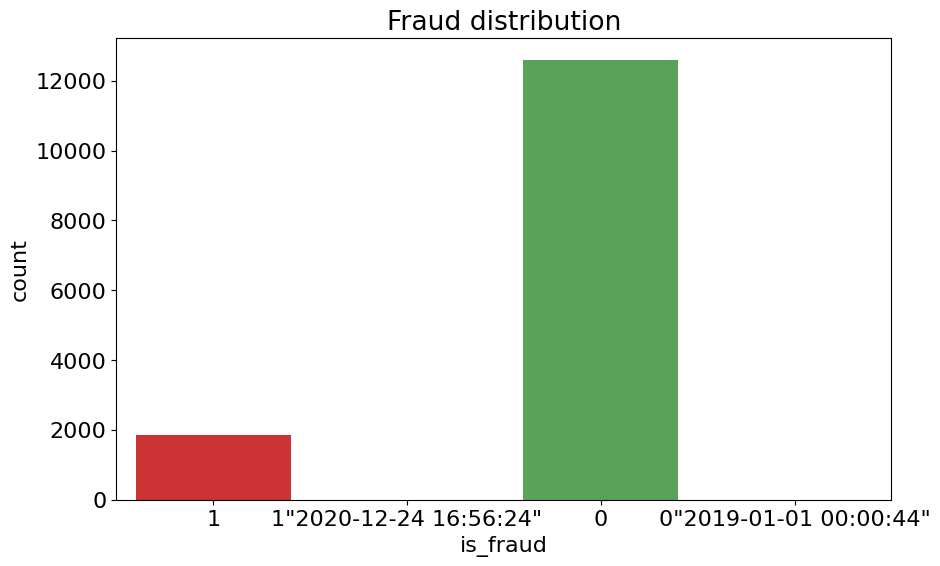

0.0


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=raw_df, x='is_fraud', palette='Set1')
plt.title('Fraud distribution')
plt.show()

print(len(raw_df[raw_df['is_fraud'] == 1]) / len(raw_df) * 100)

Vemos como efectivamente tenemos un desbalance bastante significativo, tenemos un desbalance aproximadamente de 9 a 1 y tenemos dos valores erroneos que eliminaremos posteriormente en el procesado.

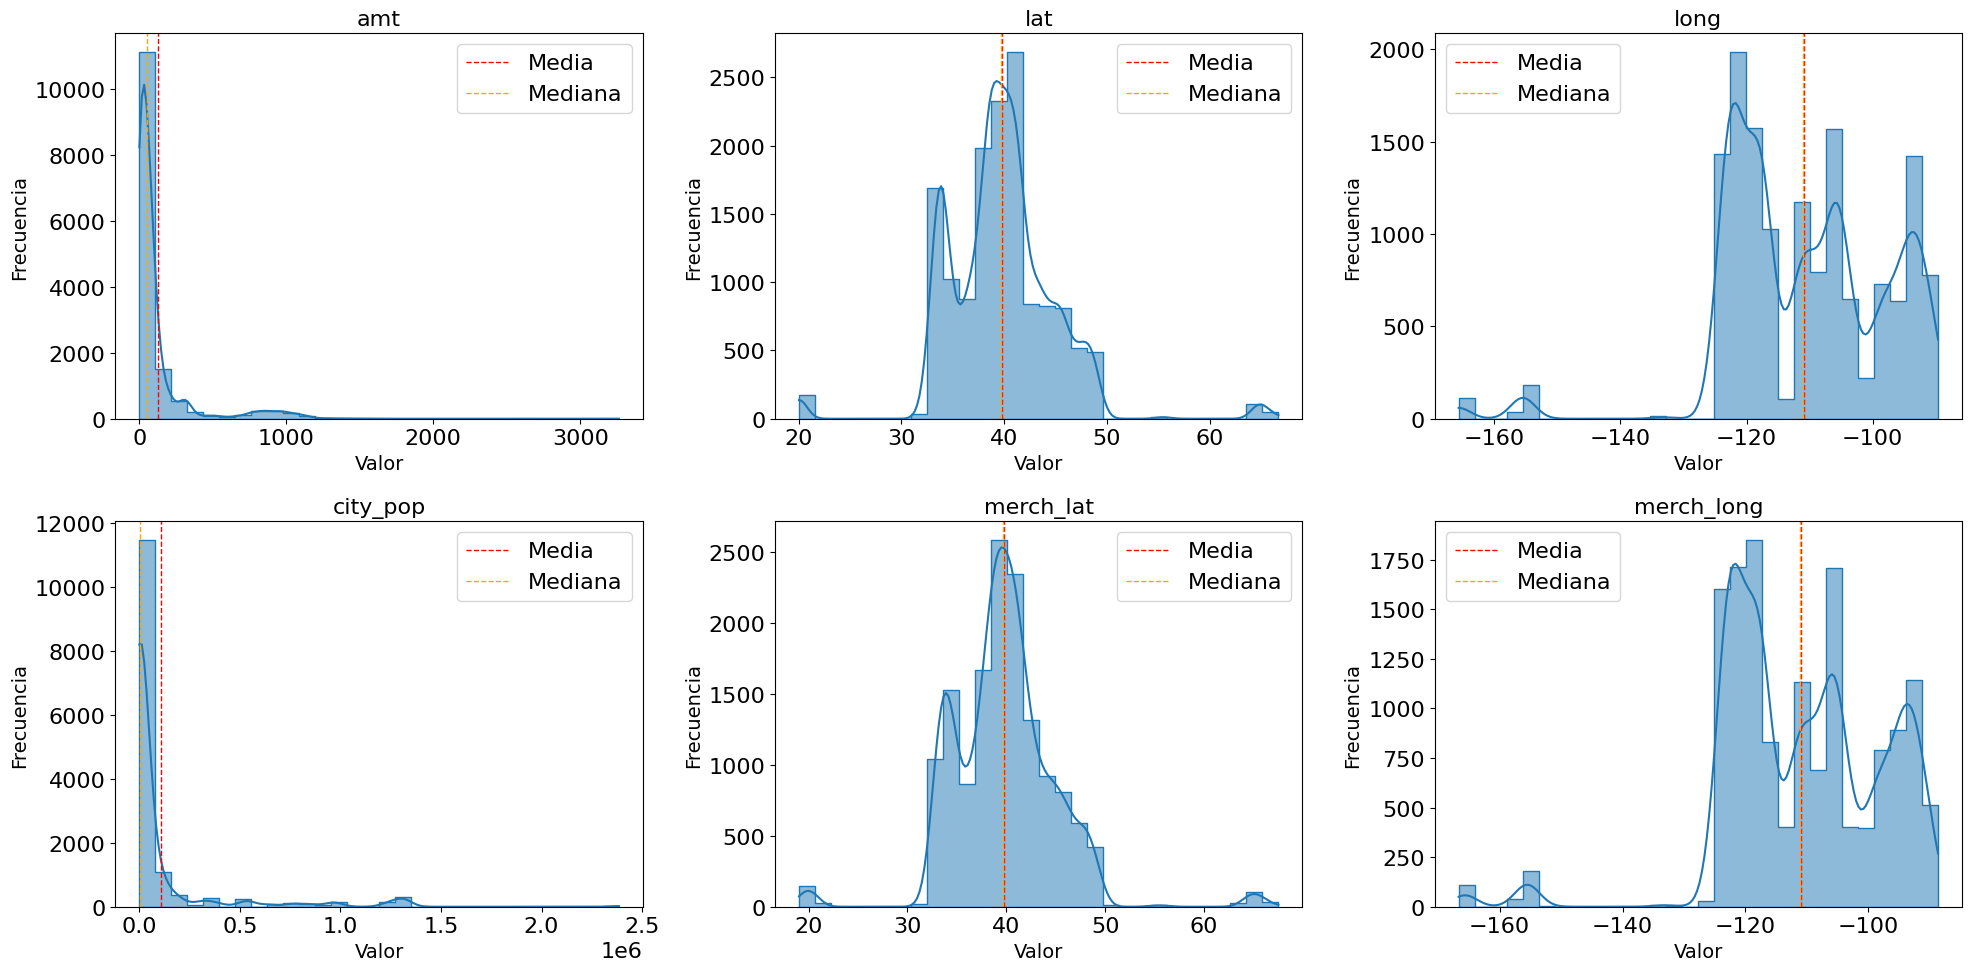

Medianas:
 amt             51.520
lat             39.666
long          -111.099
city_pop      1645.000
merch_lat       39.621
merch_long    -111.193
dtype: float64


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

numeric_columns = raw_df.select_dtypes(include=[np.number]).columns

for i, c in enumerate(numeric_columns):
    ax = axes.flatten()[i]
    sns.histplot(data=raw_df, x=c, ax=ax, bins=30, kde=True, palette='Set1', element='step')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = raw_df[c].mean()
    median = raw_df[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

# Eliminar los subplots vacíos
for j in range(i + 1, 6):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

medianas = raw_df[numeric_columns].median()
print("Medianas:\n", medianas)


Observamos como tenemos 4 variables que nos representan la latitud y la longitud y luego tenemos una varibale amt que nos indica la cantidad que se ha gastado en la transaccion que vemos que suele estar entorno a los 50 dolares, sin embargo tenemos valores que llegan hasta mas de 3000 dolares.

Dado que tenemos variables geograficas, procederemos a mostrarlaas en un grafico mas representativo

In [ ]:
import folium
from folium.plugins import HeatMap

# Crear un mapa centrado en el centro de los datos
map_center = [raw_df['lat'].mean(), raw_df['long'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Crear una lista de puntos de calor
heat_data = [[row['lat'], row['long']] for index, row in raw_df.iterrows()]

# Añadir el mapa de calor
HeatMap(heat_data).add_to(m)

# Mostrar el mapa
m


In [ ]:
import folium
from folium.plugins import HeatMap

# Crear un mapa centrado en el centro de los datos
map_center = [raw_df['merch_lat'].mean(), raw_df['merch_long'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Crear una lista de puntos de calor
heat_data = [[row['lat'], row['long']] for index, row in raw_df.iterrows()]

# Añadir el mapa de calor
HeatMap(heat_data).add_to(m)

# Mostrar el mapa
m


Vemos como sond datos de estados unidos, mas concretamente de la costa este y aglunos estados del centro como Kansas, Missouri y Colorado.

Vemos como tenemos tambien algunos datos de Hawaii y de Alaska.

In [ ]:
columnasCategoricas = raw_df.select_dtypes(include=['object']).columns

print(raw_df[columnasCategoricas].nunique())

trans_date_trans_time    12126
merchant                   693
category                    14
city                       176
state                       13
job                        163
dob                        187
trans_num                14383
is_fraud                     4
dtype: int64


Procedemos a continuación a mostrar las variables category y state dado que las otras variables catgoricas tienen un número de valores únicos muy elevado

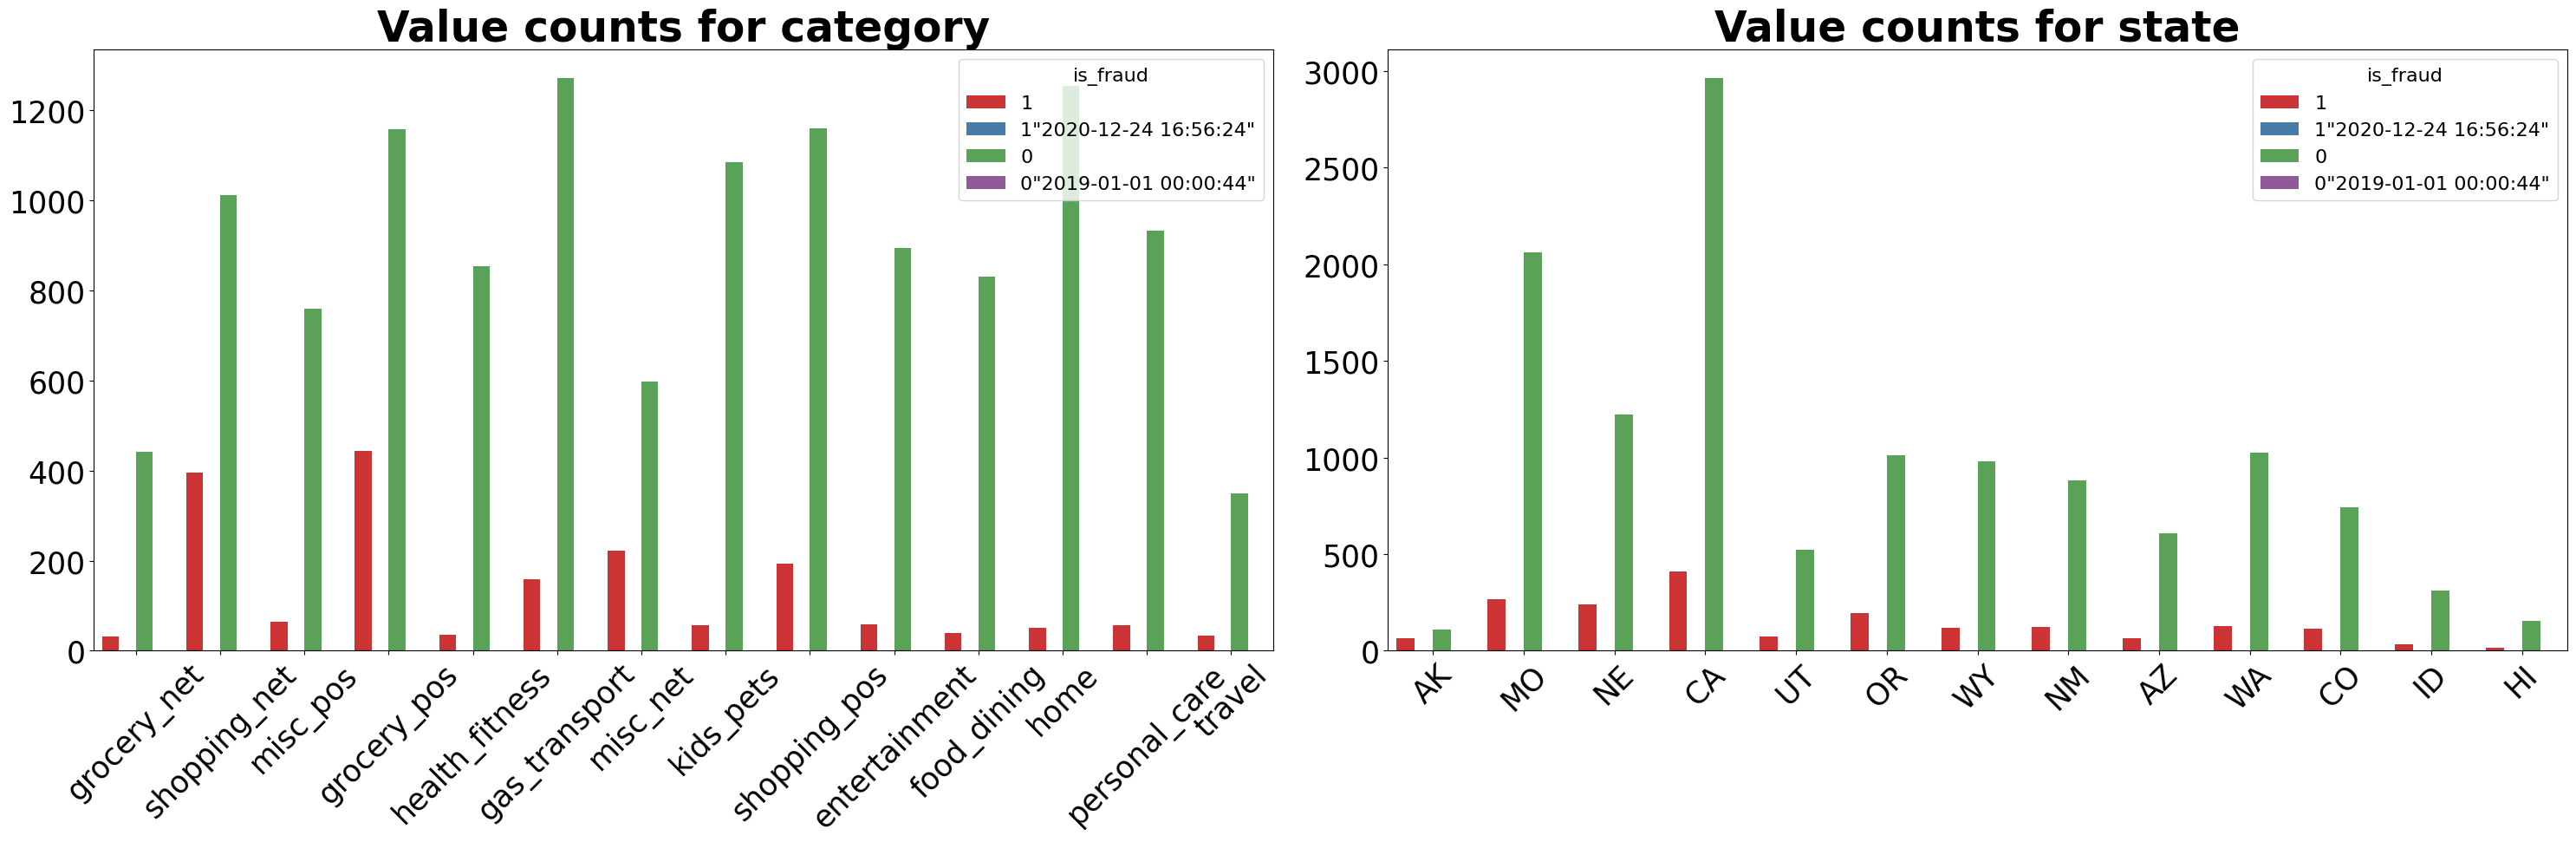

In [ ]:
import math

filtered_columns = ['category', 'state']

# Calcular el numero de filas y columnas
num_plots = len(filtered_columns)
num_cols = math.ceil(math.sqrt(num_plots))
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15 * num_cols, 10 * num_rows))

axes = axes.flatten()  # Flatten the axes array

for i, column in enumerate(filtered_columns):
    sns.countplot(x=column, hue='is_fraud', data=raw_df, ax=axes[i], palette='Set1')
    axes[i].set_title(f"Value counts for {column}", fontsize=35, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if raw_df[column].nunique() > 7:
        axes[i].tick_params(axis='x', labelsize=25, rotation=45)
    else:
        axes[i].tick_params(axis='x', labelsize=25)
    axes[i].tick_params(axis='y', labelsize=25)

# Eliminar los ejes que no se usan
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Como vemos en general las categorias estan bastante equilibradas entre ellas y vemos por otra parte que la mayoria de fraudes se cometen en la grocery_net y en misc_pos, si vemos los estados el número de fraudes suele ser proporcional al número de instancias en ese estado.

## Apartado A
El primer paso es preprocesar y preparar los datos antes de ajustar cualquier modelo. Hay algunas variables que no son útiles para el problema o que no tiene sentido usar. Eliminadlas del conjunto de datos, pero eliminad solo las más obvias, si quitáis alguna más deberéis justificar porque lo hacéis. El conjunto de datos tiene una mezcla de atributos fecha, categóricos y numéricos, transformad los categóricos a numéricos. Podéis calcular algunas variables derivadas de las variables fecha que puedan tener sentido para los datos.

Partid los datos en conjunto de entrenamiento y test (70 %/30 %).

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

Vemos que tenemos variables categóricas y númericas, pero no tenemos valores faltantes

In [ ]:
columnasCategoricas = raw_df.select_dtypes(include=['object']).columns
columnasNumericas = raw_df.select_dtypes(include=['float64', 'int64']).columns

print(raw_df[columnasCategoricas].nunique())

raw_df[columnasCategoricas].head()

trans_date_trans_time    12126
merchant                   693
category                    14
city                       176
state                       13
job                        163
dob                        187
trans_num                14383
is_fraud                     4
dtype: int64


,trans_date_trans_time,merchant,category,city,state,job,dob,trans_num,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,Wales,AK,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,Wales,AK,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,Wales,AK,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,Wales,AK,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,Wales,AK,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,1


Vemos que hay 4 valores únicos en is_fraud cuando teoricamente deberían haber dos (fraude, no fraude)

In [ ]:
raw_df['is_fraud'].value_counts()

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

Vemos como hay dos filas con valores erroneos, así que eliminamos los dos valores anómalos nuestros datos.

In [ ]:
raw_df = raw_df[raw_df['is_fraud'].isin(['0', '1'])]

print(raw_df['is_fraud'].value_counts())

print(len(raw_df))

is_fraud
0    12600
1     1844
Name: count, dtype: int64
14444


In [ ]:
raw_df['is_fraud'] = raw_df['is_fraud'].astype(int)

#### Trans_num
Eliminamos ahora la variable trans_num dado que es un valor practicamente único, es un identificador de tarjeta

In [ ]:
columnasCategoricas = raw_df.select_dtypes(include=['object']).columns
dfProcesado = raw_df.drop(columns=['trans_num'])
columnasCategoricas = columnasCategoricas.drop('trans_num')

dfProcesado[columnasCategoricas].head()

,trans_date_trans_time,merchant,category,city,state,job,dob
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,Wales,AK,"""Administrator, education""",09-11-1939
1,04-01-2019 15:06,Predovic Inc,shopping_net,Wales,AK,"""Administrator, education""",09-11-1939
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,Wales,AK,"""Administrator, education""",09-11-1939
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,Wales,AK,"""Administrator, education""",09-11-1939
4,04-01-2019 23:59,Friesen Lt,health_fitness,Wales,AK,"""Administrator, education""",09-11-1939


### Análisis variables categóricas

#### Trans_date_trans_time
Procedemos a hacer el tratamiento de las variables relacionadas con fecha y tiempo (estan en formato day-month-year)

In [ ]:
# Convertir la columna 'trans_date_trans_time' a datetime
dfProcesado['trans_date_trans_time'] = pd.to_datetime(dfProcesado['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

dfProcesado['dayTrans'] = dfProcesado['trans_date_trans_time'].dt.day
dfProcesado['monthTrans'] = dfProcesado['trans_date_trans_time'].dt.month
dfProcesado['yearTrans'] = dfProcesado['trans_date_trans_time'].dt.year
dfProcesado['hourTrans'] = dfProcesado['trans_date_trans_time'].dt.hour
dfProcesado['minuteTrans'] = dfProcesado['trans_date_trans_time'].dt.minute

# Mostrar las primeras filas para verificar
dfProcesado[['trans_date_trans_time', 'dayTrans', 'monthTrans', 'yearTrans', 'hourTrans', 'minuteTrans']].head()

,trans_date_trans_time,dayTrans,monthTrans,yearTrans,hourTrans,minuteTrans
0,2019-01-04 00:58:00,4,1,2019,0,58
1,2019-01-04 15:06:00,4,1,2019,15,6
2,2019-01-04 22:37:00,4,1,2019,22,37
3,2019-01-04 23:06:00,4,1,2019,23,6
4,2019-01-04 23:59:00,4,1,2019,23,59


In [ ]:
dfProcesado = dfProcesado.drop(columns=['trans_date_trans_time'])
columnasCategoricas = columnasCategoricas.drop('trans_date_trans_time')

dfProcesado[columnasCategoricas].head()

,merchant,category,city,state,job,dob
0,"""Stokes, Christiansen and Sipes""",grocery_net,Wales,AK,"""Administrator, education""",09-11-1939
1,Predovic Inc,shopping_net,Wales,AK,"""Administrator, education""",09-11-1939
2,Wisozk and Sons,misc_pos,Wales,AK,"""Administrator, education""",09-11-1939
3,Murray-Smitham,grocery_pos,Wales,AK,"""Administrator, education""",09-11-1939
4,Friesen Lt,health_fitness,Wales,AK,"""Administrator, education""",09-11-1939


In [ ]:
dfProcesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   merchant     14444 non-null  object 
 1   category     14444 non-null  object 
 2   amt          14444 non-null  float64
 3   city         14444 non-null  object 
 4   state        14444 non-null  object 
 5   lat          14444 non-null  float64
 6   long         14444 non-null  float64
 7   city_pop     14444 non-null  int64  
 8   job          14444 non-null  object 
 9   dob          14444 non-null  object 
 10  merch_lat    14444 non-null  float64
 11  merch_long   14444 non-null  float64
 12  is_fraud     14444 non-null  int64  
 13  dayTrans     14444 non-null  int32  
 14  monthTrans   14444 non-null  int32  
 15  yearTrans    14444 non-null  int32  
 16  hourTrans    14444 non-null  int32  
 17  minuteTrans  14444 non-null  int32  
dtypes: float64(5), int32(5), int64(2), object(6)
memory

#### Date of Birth
Para el caso de la fecha de nacimiento del titular de la tarjeta, la eliminaremos dado que no nos aporta ninguna información relevante para el problema que estamos tratando.

In [ ]:
dfProcesado = dfProcesado.drop(columns=['dob'])
columnasCategoricas = columnasCategoricas.drop('dob')

dfProcesado[columnasCategoricas].head()

,merchant,category,city,state,job
0,"""Stokes, Christiansen and Sipes""",grocery_net,Wales,AK,"""Administrator, education"""
1,Predovic Inc,shopping_net,Wales,AK,"""Administrator, education"""
2,Wisozk and Sons,misc_pos,Wales,AK,"""Administrator, education"""
3,Murray-Smitham,grocery_pos,Wales,AK,"""Administrator, education"""
4,Friesen Lt,health_fitness,Wales,AK,"""Administrator, education"""


In [ ]:
dfProcesado[columnasCategoricas].nunique()

merchant    693
category     14
city        176
state        13
job         163
dtype: int64

#### Merchant
Dado que tenemos la latitud y longitud de las cooredenadas del comerciante, el nombre del comerciante no nos aporta ninguna información importante, así que lo eliminamos

In [ ]:
dfProcesado = dfProcesado.drop(columns=['merchant'])
columnasCategoricas = columnasCategoricas.drop('merchant')
dfProcesado[columnasCategoricas].head()

,category,city,state,job
0,grocery_net,Wales,AK,"""Administrator, education"""
1,shopping_net,Wales,AK,"""Administrator, education"""
2,misc_pos,Wales,AK,"""Administrator, education"""
3,grocery_pos,Wales,AK,"""Administrator, education"""
4,health_fitness,Wales,AK,"""Administrator, education"""


### Ciudad y estado
A continuación nos damos cuenta que nos pasa lo mismo con el estado y la ciudad, el nombre no nos aporta ninguna información importante, nos importa so localización y dado que tenemos la latitud y la longitud de la compra, prescindiremos tanto de la variable estado como de la variable ciudad.

In [ ]:
dfProcesado = dfProcesado.drop(columns=['city', 'state'])
columnasCategoricas = columnasCategoricas.drop(['city', 'state'])
dfProcesado[columnasCategoricas].head()

,category,job
0,grocery_net,"""Administrator, education"""
1,shopping_net,"""Administrator, education"""
2,misc_pos,"""Administrator, education"""
3,grocery_pos,"""Administrator, education"""
4,health_fitness,"""Administrator, education"""


#### Categoria y trabajo
Vemos como ahora solo nos queda la variable category, a la que le podemos aplicar one-hot encoding dado que solo tiene 14 valores únicos y por otra parte la variable job que no podemos aplicarle one-hot encoding debido al exceso de valores únicos que tiene, así que o bien aplicamos un label encoding (sacrificando la inducción de un orden no existente en la variable) o bien intentamos ver si podemos hacer un poco de feture engineering o bien prescindimos de esa variable.

In [ ]:
unique_jobs = dfProcesado['job'].unique()
unique_jobs_array = unique_jobs.tolist()
print(unique_jobs_array)

# guardar unique_jobs_array en un archivo .txt
with open('unique_jobs_array.txt', 'w') as f:
    for item in unique_jobs_array:
        f.write("%s\n" % item)

['"Administrator, education"', 'Cytogeneticist', '"Solicitor, Scotland"', 'Science writer', 'Product designer', '"Surveyor, minerals"', 'Marketing executive', 'Comptroller', 'Electronics engineer', 'Clinical cytogeneticist', '"Engineer, site"', 'Armed forces training and education officer', 'Tourist information centre manager', '"Administrator, local government"', 'Systems analyst', 'Charity officer', 'Public relations account executive', 'Set designer', 'Information systems manager', 'Occupational hygienist', 'Counsellor', 'Land/geomatics surveyor', 'Landscape architect', '"Buyer, industrial"', 'Research scientist (physical sciences)', 'Airline pilot', 'Careers information officer', '"Pilot, airline"', 'Industrial/product designer', '"Nurse, mental health"', 'Health physicist', '"Scientist, audiological"', 'Health service manager', '"Scientist, physiological"', 'Cartographer', 'Chartered legal executive (England and Wales)', 'Civil Service administrator', 'Further education lecturer',

Para ello crearemos dos datasets distintos, uno con la variable trabajo transformada con labelencoding y uno aplicando un clustering entre los valores únicos agrupandolos en 15 hipertipos y posteriormente haciendo one-hot-encoding a la variable.

##### One-hot encoding

In [ ]:
def remove_quotes(job):
    return re.sub(r'^"|"$', '', job)

dfProcesado['job'] = dfProcesado['job'].apply(remove_quotes)

unique_jobs = dfProcesado['job'].unique()
unique_jobs_array = unique_jobs.tolist()
print(unique_jobs_array)

# guardar unique_jobs_array en un archivo .txt
with open('unique_jobs_array.txt', 'w') as f:
    for item in unique_jobs_array:
        f.write("%s\n" % item)

dfProcesado['job'].value_counts()

['Administrator, education', 'Cytogeneticist', 'Solicitor, Scotland', 'Science writer', 'Product designer', 'Surveyor, minerals', 'Marketing executive', 'Comptroller', 'Electronics engineer', 'Clinical cytogeneticist', 'Engineer, site', 'Armed forces training and education officer', 'Tourist information centre manager', 'Administrator, local government', 'Systems analyst', 'Charity officer', 'Public relations account executive', 'Set designer', 'Information systems manager', 'Occupational hygienist', 'Counsellor', 'Land/geomatics surveyor', 'Landscape architect', 'Buyer, industrial', 'Research scientist (physical sciences)', 'Airline pilot', 'Careers information officer', 'Pilot, airline', 'Industrial/product designer', 'Nurse, mental health', 'Health physicist', 'Scientist, audiological', 'Health service manager', 'Scientist, physiological', 'Cartographer', 'Chartered legal executive (England and Wales)', 'Civil Service administrator', 'Further education lecturer', 'Location manager',

job
Surveyor, minerals              262
Surveyor, land/geomatics        240
Land/geomatics surveyor         225
Insurance broker                209
Electronics engineer            197
                               ... 
Landscape architect               9
Systems developer                 9
Information officer               8
Research scientist (medical)      8
Clinical cytogeneticist           7
Name: count, Length: 163, dtype: int64

Una vez analizados todos los trabajaos, creamos un diccionario para mapear cada trabajo a un hipertipo

In [ ]:
job_categories = {
    "education": [
        "Administrator, education", "Education administrator", "Early years teacher",
        "Further education lecturer", "Lecturer, higher education", "Museum education officer",
        "Private music teacher", "Teacher, adult education", "Teacher, early years/pre-school",
        "Learning mentor", "Teacher, early years/pre", "Education officer, museum", "Associate Professor",
        "Educational psychologist", "TEFL teacher", "Special educational needs teacher"
    ],
    "healthcare": [
        "Nurse, mental health", "Nurse, children's", "Mental health nurse",
        "Physiotherapist", "Music therapist", "Therapist, art",
        "Therapist, occupational", "Therapist, horticultural", "Chiropodist",
        "Podiatrist", "Osteopath", "Pharmacist, hospital", "Health service manager",
        "Radiographer, diagnostic", "Medical technical officer", "Exercise physiologist",
        "Therapist, music", "Counselling psychologist"
    ],
    "science": [
        "Cytogeneticist", "Clinical cytogeneticist", "Research scientist (physical sciences)",
        "Research scientist (medical)", "Research scientist (maths)", "Soil scientist",
        "Scientist, marine", "Health physicist", "Scientist, audiological",
        "Scientist, physiological", "Geoscientist", "Product/process development scientist",
        "Forensic psychologist", "Scientist, research (maths)", "Colour technologist",
        "Clinical research associate", "Teaching laboratory technician", "Intelligence analyst"
    ],
    "engineering": [
        "Electronics engineer", "Engineer, site", "Petroleum engineer",
        "Engineer, production", "Engineer, maintenance", "Engineer, agricultural",
        "Engineer, automotive", "Engineer, biomedical", "Engineer, communications",
        "Engineer, civil (consulting)", "Engineer, building services", "Engineer, petroleum",
        "Aeronautical engineer", "Materials engineer", "Metallurgist", "Engineer, electronics",
        "Telecommunications researcher", "Chemical engineer"
    ],
    "construction": [
        "Architect", "Architectural technologist", "Landscape architect",
        "Civil engineer, contracting", "Building surveyor", "Planning and development surveyor",
        "Town planner", "Geologist, engineering", "Historic buildings inspector/conservation officer",
        "Occupational hygienist", "Contractor", "Naval architect"
    ],
    "arts": [
        "Set designer", "Fine artist", "Web designer",
        "Product designer", "Industrial/product designer", "Clothing/textile technologist",
        "Designer, exhibition/display", "Glass blower/designer", "Cartographer",
        "Location manager", "Musician"
    ],
    "media": [
        "Science writer", "Magazine features editor", "Editor, magazine features",
        "Journalist, newspaper", "Video editor", "Television/film/video producer",
        "Television floor manager", "Commissioning editor", "Radio broadcast assistant"
    ],
    "sales": [
        "Marketing executive", "Public relations account executive", "Chief Marketing Officer",
        "Sales executive", "Sales professional, IT", "Retail merchandiser",
        "Advertising account planner", "Buyer, industrial", "Human resources officer", "Hotel manager",
        "Production manager"
    ],
    "business": [
        "Accountant, chartered", "Chartered public finance accountant", "Comptroller",
        "Investment banker, corporate", "Futures trader", "Investment analyst",
        "Insurance broker", "Tax inspector", "Public house manager", "Economist"
    ],
    "legalService": [
        "Solicitor, Scotland", "Chartered legal executive (England and Wales)",
        "Barrister", "Licensed conveyancer"
    ],
    "publicService": [
        "Civil Service administrator", "Civil Service fast streamer", "Immigration officer",
        "Local government officer", "Administrator, local government", "Tax inspector",
        "Research officer, political party", "Public librarian"
    ],
    "technology": [
        "Systems analyst", "Information systems manager", "IT consultant",
        "Network engineer", "Systems developer"
    ],
    "socialWork": [
        "Careers information officer", "Community arts worker", "Development worker, international aid",
        "Charity officer", "Learning mentor", "Counsellor",
        "Occupational psychologist", "Tourist information centre manager", "Information officer"
    ],
    "naturalResources": [
        "Surveyor, minerals", "Surveyor, mining", "Land/geomatics surveyor",
        "Nature conservation officer", "Water engineer", "Wellsite geologist","Surveyor, land/geomatics",
        "Agricultural consultant"
    ],
    "miscellaneous": [
        "Airline pilot", "Pilot, airline", "Armed forces training and education officer",
        "Firefighter", "Call centre manager", "Dealer",
        "Freight forwarder", "Barista", "Museum/gallery exhibitions officer",
        "Osteopath"
    ]
}

dfProcesado_onehot = dfProcesado.copy()

def rename_job(job):
    for category, jobs in job_categories.items():
        if job in jobs:
            return category
    return job

dfProcesado_onehot['job'] = dfProcesado_onehot['job'].apply(rename_job)

In [ ]:
unique_jobs = dfProcesado_onehot['job'].unique()
unique_jobs_array = unique_jobs.tolist()
print(unique_jobs_array)

# guardar unique_jobs_array en un archivo .txt
with open('clustering_jobs_array.txt', 'w') as f:
    for item in unique_jobs_array:
        f.write("%s\n" % item)

dfProcesado_onehot['job'].nunique()

['education', 'science', 'legalService', 'media', 'arts', 'naturalResources', 'sales', 'business', 'engineering', 'miscellaneous', 'socialWork', 'publicService', 'technology', 'construction', 'healthcare']


15

Observamos como efectivamente ahora solo tenemos 15 valores en la variable y por lo tanto ya la podemos codificar mediante one-hot.

Procedemos a visualizar ahora que podemos el countplot con la transformación de la variable

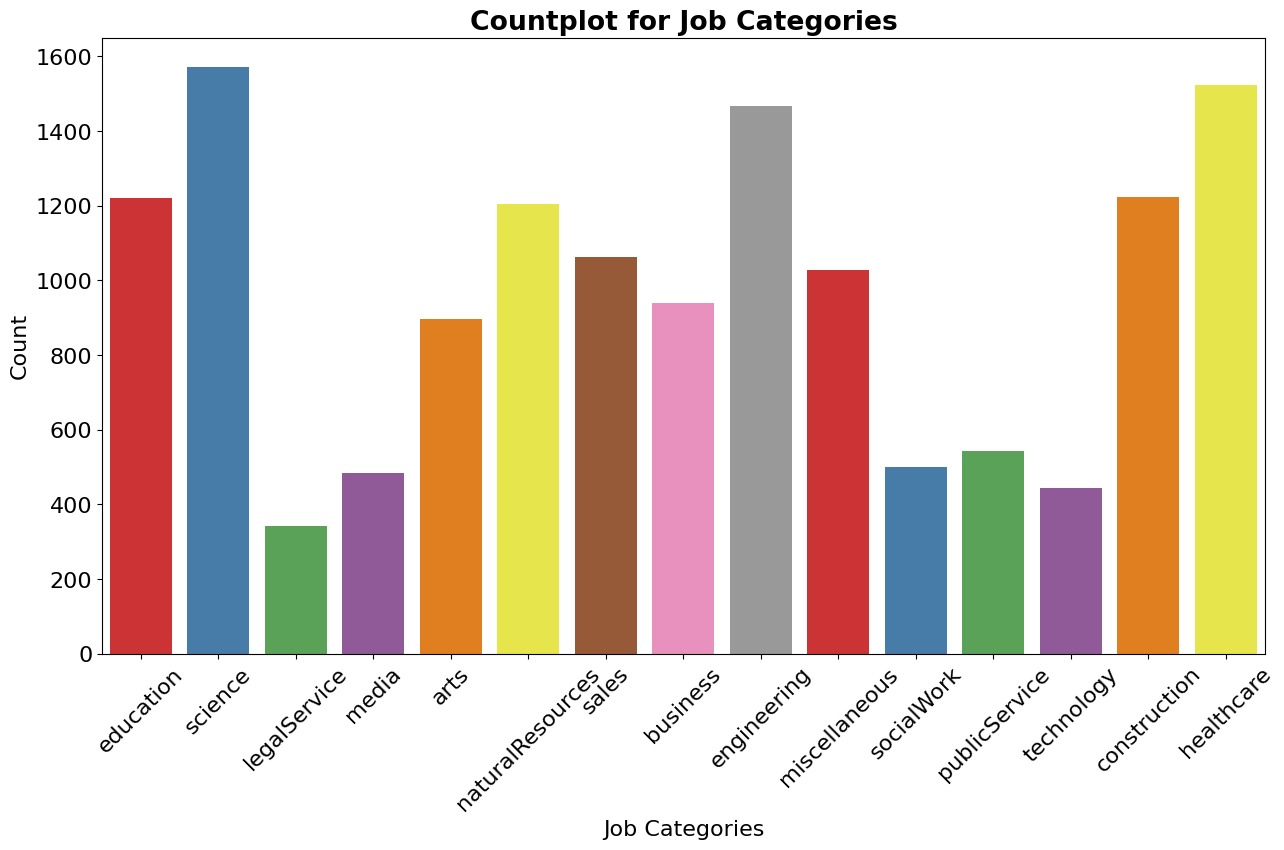

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(data=dfProcesado_onehot, x='job', palette='Set1')
plt.title('Countplot for Job Categories', fontweight='bold')
plt.xlabel('Job Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Vemos como hay hipertipos mas representados que otros pero no hay una desproporcion en alguna clase que se peuda considerar excesiva.

In [ ]:
dfProcesado_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     14444 non-null  object 
 1   amt          14444 non-null  float64
 2   lat          14444 non-null  float64
 3   long         14444 non-null  float64
 4   city_pop     14444 non-null  int64  
 5   job          14444 non-null  object 
 6   merch_lat    14444 non-null  float64
 7   merch_long   14444 non-null  float64
 8   is_fraud     14444 non-null  int64  
 9   dayTrans     14444 non-null  int32  
 10  monthTrans   14444 non-null  int32  
 11  yearTrans    14444 non-null  int32  
 12  hourTrans    14444 non-null  int32  
 13  minuteTrans  14444 non-null  int32  
dtypes: float64(5), int32(5), int64(2), object(2)
memory usage: 1.4+ MB


Procedemos ahora a hacer el one-hot econding de las dos varibales categóricas que nos quedan

In [ ]:
dfProcesado_onehot = pd.get_dummies(dfProcesado_onehot, columns=['category', 'job'])

dfProcesado_onehot.head()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,dayTrans,monthTrans,yearTrans,...,job_healthcare,job_legalService,job_media,job_miscellaneous,job_naturalResources,job_publicService,job_sales,job_science,job_socialWork,job_technology
0,14.37,64.756,-165.672,145,65.654,-164.723,1,4,1,2019,...,False,False,False,False,False,False,False,False,False,False
1,966.11,64.756,-165.672,145,65.469,-165.473,1,4,1,2019,...,False,False,False,False,False,False,False,False,False,False
2,49.61,64.756,-165.672,145,65.348,-165.915,1,4,1,2019,...,False,False,False,False,False,False,False,False,False,False
3,295.26,64.756,-165.672,145,64.445,-166.080,1,4,1,2019,...,False,False,False,False,False,False,False,False,False,False
4,18.17,64.756,-165.672,145,65.447,-165.447,1,4,1,2019,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
dfProcesado_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   amt                      14444 non-null  float64
 1   lat                      14444 non-null  float64
 2   long                     14444 non-null  float64
 3   city_pop                 14444 non-null  int64  
 4   merch_lat                14444 non-null  float64
 5   merch_long               14444 non-null  float64
 6   is_fraud                 14444 non-null  int64  
 7   dayTrans                 14444 non-null  int32  
 8   monthTrans               14444 non-null  int32  
 9   yearTrans                14444 non-null  int32  
 10  hourTrans                14444 non-null  int32  
 11  minuteTrans              14444 non-null  int32  
 12  category_entertainment   14444 non-null  bool   
 13  category_food_dining     14444 non-null  bool   
 14  category_gas_transport   14

Finalmente observamos como nos queda un dataset con 41 columnas y 14445 filas.

##### Label encoding para job

Procedemos ahora a realizar el label encoding para job

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dfProcesado_labeling = dfProcesado.copy()
dfProcesado_labeling['job'] = label_encoder.fit_transform(dfProcesado_labeling['job'])

dfProcesado_labeling = pd.get_dummies(dfProcesado_labeling, columns=['category'])

dfProcesado_labeling.head()

,amt,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,dayTrans,monthTrans,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,14.37,64.756,-165.672,145,1,65.654,-164.723,1,4,1,...,False,False,False,False,False,False,False,False,False,False
1,966.11,64.756,-165.672,145,1,65.469,-165.473,1,4,1,...,False,False,False,False,False,False,False,True,False,False
2,49.61,64.756,-165.672,145,1,65.348,-165.915,1,4,1,...,False,False,False,False,False,True,False,False,False,False
3,295.26,64.756,-165.672,145,1,64.445,-166.080,1,4,1,...,True,False,False,False,False,False,False,False,False,False
4,18.17,64.756,-165.672,145,1,65.447,-165.447,1,4,1,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
dfProcesado_labeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   amt                      14444 non-null  float64
 1   lat                      14444 non-null  float64
 2   long                     14444 non-null  float64
 3   city_pop                 14444 non-null  int64  
 4   job                      14444 non-null  int64  
 5   merch_lat                14444 non-null  float64
 6   merch_long               14444 non-null  float64
 7   is_fraud                 14444 non-null  int64  
 8   dayTrans                 14444 non-null  int32  
 9   monthTrans               14444 non-null  int32  
 10  yearTrans                14444 non-null  int32  
 11  hourTrans                14444 non-null  int32  
 12  minuteTrans              14444 non-null  int32  
 13  category_entertainment   14444 non-null  bool   
 14  category_food_dining     14

Vemos como en este dataset nos quedan 27 columnas.

Guardamos los dos datasets para posteriormente ver que preprocesado obtiene mejores resultados

In [ ]:
datasets = [dfProcesado_onehot, dfProcesado_labeling]

### Conjunto entrenamiento y test

Por defecto usaremos el dataset con el preprocesado de one-hot encoding mediante un previo clustering en la variable trabajo. Cabe destacar que realizamos la partición train/test de forma estratificada, debido al gran desbalance de nuestras clases.

In [ ]:
dfPostProcesado = datasets[0]

In [ ]:
X = dfPostProcesado.drop(columns=['is_fraud'])
y = dfPostProcesado['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Tenemos las versiones estandarizada y normaliza, segun el modelo es mejor una opcion u otra
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

scalerMM = MinMaxScaler()
X_train_norm = scalerMM.fit_transform(X_train)
X_test_norm = scalerMM.transform(X_test)

X_train_std.shape, X_test_std.shape

((10110, 40), (4334, 40))

## Apartado B

Comenzaremos con un modelo de predicción base ajustando una regresión logística. Fijaos que los que nos interesa es que la mejor predicción sea para la clase fraude. Evaluad el modelo. Este modelo puede penalizar los errores en las clases minoritarias usando el parámetro class_weight. Usad el valor balanced y comprobad si eso mejora el modelo. Comprobad las curvas ROC.

### Rregresión sin balancing

Procedemos primero a hacer una breve exploración de hiperparametros para el modelo sin usar balancing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':10**np.linspace(-3,3,21, endpoint=True),
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_std, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")

best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test_std)
y_pred_proba_best = best_log_reg.predict_proba(X_test_std)[:, 1]

Best parameters: {'C': np.float64(0.501187233627272), 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
Best AUC score: 0.9043641572974689


In [ ]:
auc_score_best = roc_auc_score(y_test, y_pred_proba_best)
print(f'AUC with best parameters: {auc_score_best}')

AUC with best parameters: 0.9187949837700924


In [ ]:
param_grid_balanced = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':10**np.linspace(-3,3,21, endpoint=True),
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [10000]
}

log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42)

grid_search_balanced = GridSearchCV(log_reg_balanced, param_grid_balanced, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_balanced.fit(X_train_std, y_train)

print(f"Best parameters (balanced): {grid_search_balanced.best_params_}")
print(f"Best AUC score (balanced): {grid_search_balanced.best_score_}")

best_log_reg_balanced = grid_search_balanced.best_estimator_
y_pred_best_balanced = best_log_reg_balanced.predict(X_test_std)
y_pred_proba_best_balanced = best_log_reg_balanced.predict_proba(X_test_std)[:, 1]

Best parameters (balanced): {'C': np.float64(0.25118864315095796), 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
Best AUC score (balanced): 0.915807261994767


In [ ]:
auc_score_best_balanced = roc_auc_score(y_test, y_pred_proba_best_balanced)
print(f'AUC with best parameters (balanced): {auc_score_best_balanced}')

AUC with best parameters (balanced): 0.9274745288257219


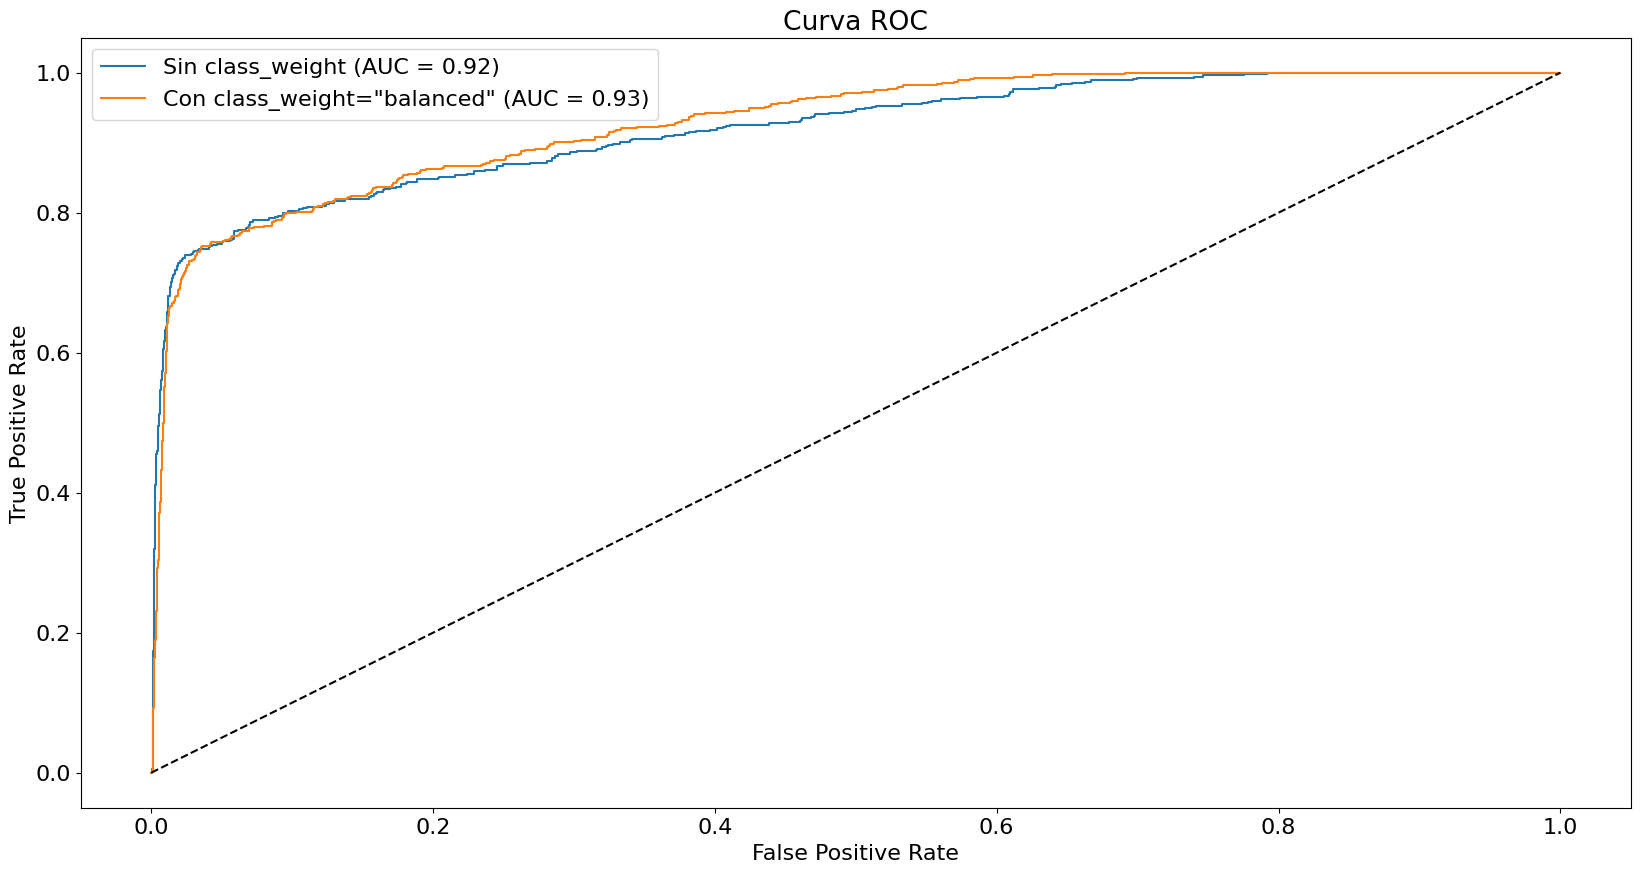

In [ ]:
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
fpr_best_balanced, tpr_best_balanced, _ = roc_curve(y_test, y_pred_proba_best_balanced)

plt.figure(figsize=(20, 10))
plt.plot(fpr_best, tpr_best, label=f'Sin class_weight (AUC = {auc_score_best:.2f})')
plt.plot(fpr_best_balanced, tpr_best_balanced, label=f'Con class_weight="balanced" (AUC = {auc_score_best_balanced:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

Vemos como los dos modelos son muy parecidos, apreciamos que con el modelo sin class_weight podemos sacrificar una tasa de falsos positivos mas baja para conseguir una tasa de verdaderos positivos mas alta, pero mas adelante vemos como las gráficas se cruzan y el modelo con class_weight se comporta mejor, a partir de un 20% de Falsos Positivos ya obtenemos mejores resultados en los verdaderos positivos que con el modelo que no usa class_weight.

In [ ]:
y_pred_log_reg = best_log_reg.predict(X_test_std)
print("Log Regression SIN class_weight:")
print(classification_report(y_test, y_pred_log_reg))

y_pred_log_reg_balanced = best_log_reg_balanced.predict(X_test_std)
print("Log Regression CON class_weight:")
print(classification_report(y_test, y_pred_log_reg_balanced))

Log Regression SIN class_weight:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3781
           1       0.91      0.61      0.73       553

    accuracy                           0.94      4334
   macro avg       0.93      0.80      0.85      4334
weighted avg       0.94      0.94      0.94      4334

Log Regression CON class_weight:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3781
           1       0.49      0.81      0.61       553

    accuracy                           0.87      4334
   macro avg       0.73      0.84      0.77      4334
weighted avg       0.91      0.87      0.88      4334



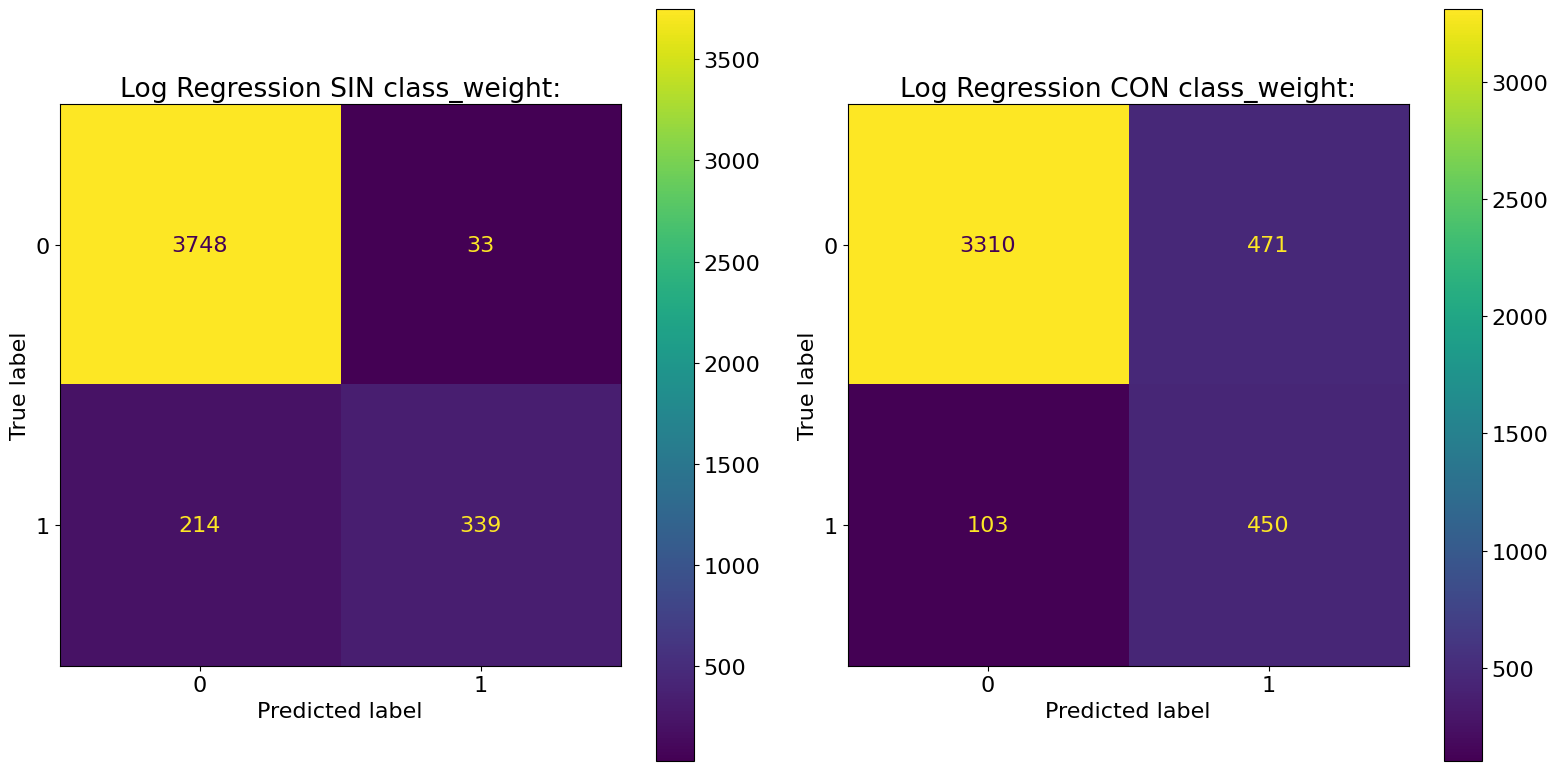

In [ ]:
plt.figure(figsize=(16, 8))

ax1 = plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(best_log_reg, X_test_std, y_test, ax=ax1)
ax1.set_title('Log Regression SIN class_weight:')

ax2 = plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(best_log_reg_balanced, X_test_std, y_test, ax=ax2)
ax2.set_title('Log Regression CON class_weight:')

plt.tight_layout()
plt.show()

Si observamos por otra parte los dos classification reports y las dos matrices de confusion vemos como pese a que el modelo obtenga una AUC de mas del 92%, eso es debido a que las clases estan muy desbalanceadas y vemos como en ambos modelos la clase minoritaria (la que mas nos interesa) no tiene unos resultados muy interesantes.

Por otra parte, observamos una cosa curiosa y es que si nos fijamos en la metrica f1 score, en el primer modelo, obtenemos un 12% mas que con el segundo modelo, sin embargo, esto es debido a que el primer modelo se comporta muy bien en cuanto a precision pero no tanto con el recall, que es la métrica que realmente nos interesa en este problema (dado que preferimos detectar un fraude y despues ya diagnosticarlo como no fraude, a no detectar un posible fraude y entonces ya no poder tratarlo de ninguna forma). El segundo modelo en cambio, mejora con creces el recall obteniendo 21 puntos mas que el primero y empeora la precision a casi la mitad.

Así que podemos concluir con que la regresión logística no obtiene unos resultados que podamos considerar satisfactorios.

In [ ]:
show_html(pd.DataFrame(grid_search.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())
results_df = save_results(grid_search, X_test_std, y_test, 'Logistic Regression SIN class_weight', results_df)

show_html(pd.DataFrame(grid_search_balanced.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())
results_df = save_results(grid_search_balanced, X_test_std, y_test, 'Logistic Regression CON class_weight', results_df)

show_html(results_df.sort_values(by='recall score (M)', ascending=False).to_html())

,params,mean_test_score,rank_test_score
83,"{'C': 0.501187233627272, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}",0.904,1
104,"{'C': 1.9952623149688788, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}",0.904,2
113,"{'C': 3.981071705534969, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}",0.904,3
92,"{'C': 1.0, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}",0.904,4
122,"{'C': 7.943282347242813, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}",0.904,5


,params,mean_test_score,rank_test_score
74,"{'C': 0.25118864315095796, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}",0.916,1
73,"{'C': 0.25118864315095796, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}",0.916,2
83,"{'C': 0.501187233627272, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}",0.916,3
82,"{'C': 0.501187233627272, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}",0.916,4
119,"{'C': 7.943282347242813, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}",0.916,5


,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Logistic Regression CON class_weight,0.916,0.868,0.729,0.845,0.765
Logistic Regression SIN class_weight,0.904,0.943,0.929,0.802,0.851


## Apartado C

Nos interesará también entender qué delata una transacción como fraudulenta. Podemos
ajustar un árbol de decisión para obtener un modelo interpretable. Ajustad este modelo
explorando adecuadamente sus hiperparámetros. Evaluad la calidad del modelo y comparadla con el anterior. Representad el árbol de decisión, ¿es suficientemente simple para
saber cuándo una transacción es fraudulenta?

Empezaremos ajustando el árbol de decisión explorando adecuadamente sus hiperparámetros. Para la exploración usaremos Bayesian Search en vez de una búsqueda exhaustiva, ya que tenemos bastantes ejemplos y la ejecución podria tardar. Además, lo bueno de los árboles de decisión es que a priori no es necesario estandarizar ni normalizar los datos.

In [ ]:
# Definimos el modelo base
dt = DecisionTreeClassifier(random_state=0)

# Hiperparámetros típicos a explorar
param_grid = {
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1,2,3,5,10],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes':[5, 10, 20, 30]
}

dt_bs = BayesSearchCV(
    estimator=dt,
    search_spaces=param_grid,
    cv=5,
    n_jobs=-1,
    refit=True,
    random_state=0,
    n_iter=40
);

dt_bs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(dt_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
21,"{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'splitter': 'best'}",0.991,1
10,"{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 30, 'min_samples_leaf': 3, 'splitter': 'best'}",0.991,2
1,"{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 30, 'min_samples_leaf': 3, 'splitter': 'best'}",0.990,3
33,"{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'splitter': 'best'}",0.988,4
32,"{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'splitter': 'best'}",0.988,5


Vemos como los 2 mejores conjuntos de hiperparámetros ofrecen aparentemente el mismo rendimiento en la partición de train. Nos quedaremos con el que aparezca primero. Lo destacable es que ambos usan el criterio de gini como media de impureza de un nodo, y el splitter 'best'. Vamos a ver como se comporta el mejor modelo en la partición de test:

In [ ]:
print(classification_report(y_test, dt_bs.predict(X_test)))
results_df = save_results(dt_bs, X_test, y_test, 'Árbol de decisión', results_df)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3781
           1       0.98      0.94      0.96       553

    accuracy                           0.99      4334
   macro avg       0.99      0.97      0.98      4334
weighted avg       0.99      0.99      0.99      4334



El modelo es muy bueno, el mejor hasta el momento. Es práctiamente perfecto en la clase mayoritaria e incluso en la clase minoritaria. Podemos ver también la matriz de confusión:

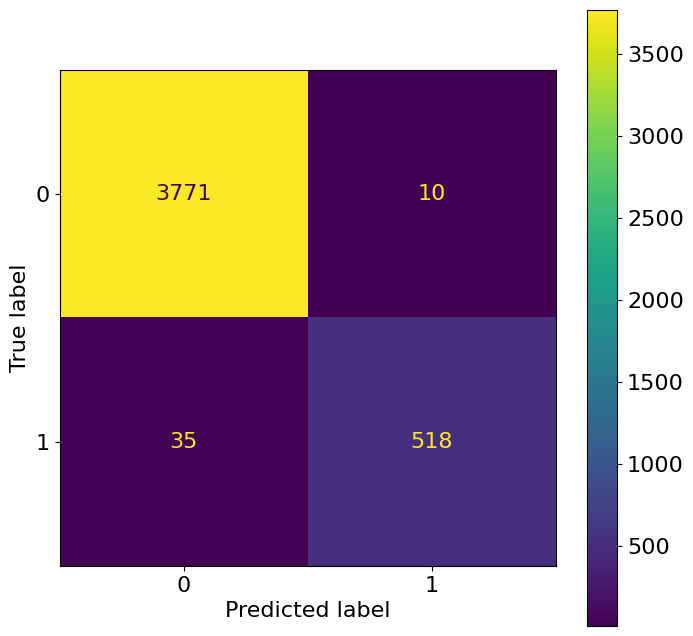

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(dt_bs, X_test,y_test, ax=plt.subplot());

Vemos como a pesar que aun predice algunos fraudes como no-fraudes, la gran mayoria se clasifican bien.

Ahora que ya hemos visto el rendimiento del modelo en la partición de test, representamos el árbol de decisión resultante, para ver si es suficientemente simple como para saber qué es lo que hace que una transacción sea fraudulenta:

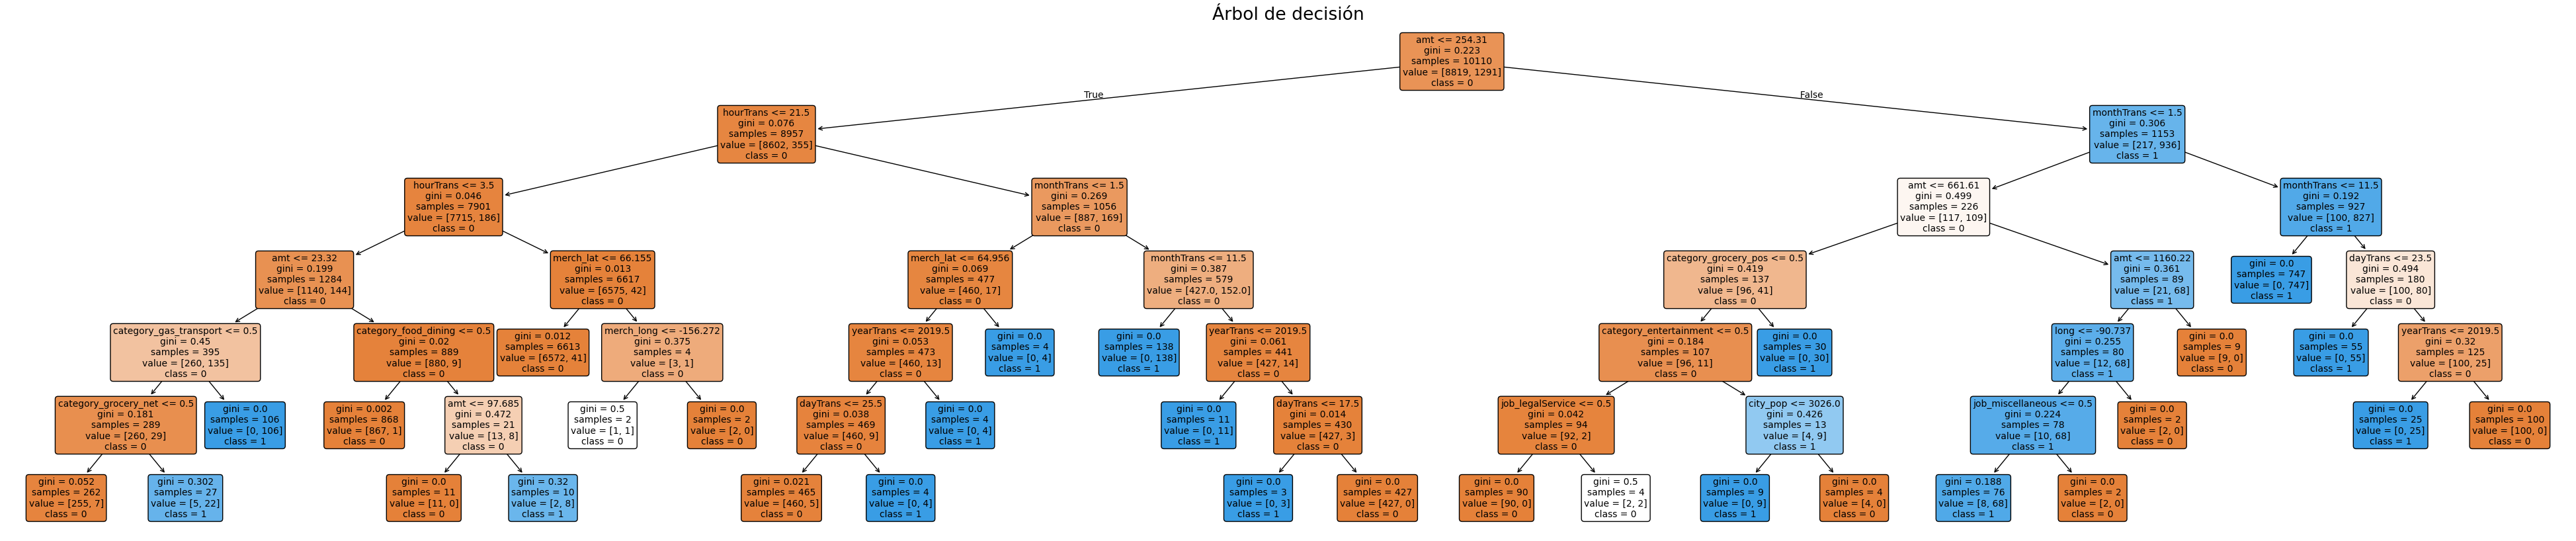

In [ ]:
# Obtenemos el mejor árbol después de la grid_search
best_tree = dt_bs.best_estimator_

# Lo visualizamos con plot_tree
plt.figure(figsize=(50, 10))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=[str(cls) for cls in best_tree.classes_],
    filled=True,         # La intensidad del color indicará la pureza
    rounded=True,
    fontsize=10
)
plt.title("Árbol de decisión")
plt.show()

Como puede que no se acabe de ver muy bien ya que el arbol no es tan sencillo, hemos decidido exportar el arbol a pdf. En la entrega hemos adjuntado el pdf del árbol de decisión.

Podemos ver que hay varios atributos que en nodos mas profundos del árbol deciden si un ejemplo es fraudulento o no. De todos modos, podemos destacar los siguientes atributos que definen en este árbol si un ejemplo es fraudulento o no:
- **amt**: Son las siglas de Amount of transaction, se trata del atributo presente en la raiz del árbol y discriminma muchos ejemplos fraudulentos de no-fraudulentos. Si la cantidad de dinero es superior a 254.31 es bastante mas probable que la transacción sea fraudulenta.
- **monthTrans**. Si la transacción es superior a 254.31 y ademas el mes de la transacción NO es ni enero ni diciembre entonces según el árbol la transacción deberia ser clasificada como fraudulenta. Esto tiene mucho sentido, ya que diciembre y enero son fechas festivas donde es habitual realizar transacciones de bastante dinero.
- Cabe destacar que si la transacción es superior a esos 254.31, en caso de ser en enero o diciembre, el árbol no clasifica de forma sistemática como no-fraudulento. En esos casos se sigue bajando por el árbol, teniendo en cuenta otros atributos. Por ejemplo si la transacción es superior a dicha cantidad y se realizo en enero, si la cantidad es superior a 661.61 entonces es mas probable que sea fraudulenta. Hay muchos otros atributos que se tienen en cuenta, como **grosery_pos**, que hace referencia a una transacción realizada físicamente en un supermercado o tienda.
- De igual modo, si en la raiz del árbol se detecta un ejemplo con menos de 254.3, éste no se clasifica directamente como no-fraudulento, sino que se sigue bajando por el árbol ya que cierta combinación de características podria llevar a la conclusión de que el ejemplo es realmentye fraudulento.

En conclusión, el árbol si que es suficientemente simple como para poder extraer características clave para la toma de decisiones. En la siguiente tabla se ve reflejada la mejora significativa obtenida:

In [ ]:
show_html(results_df.sort_values(by='recall score (M)', ascending=False).to_html())

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Árbol de decisión,0.991,0.990,0.986,0.967,0.976
Logistic Regression CON class_weight,0.916,0.868,0.729,0.845,0.765
Logistic Regression SIN class_weight,0.904,0.943,0.929,0.802,0.851


## Apartado D

Buscamos la máxima precisión en la clasificación de transacciones fraudulentas. Ajustad
un random forest y un gradient boosting explorando adecuadamente sus hiperparámetros.
Comparad los resultados con los modelos anteriores.

### Random Forest

Empezaremos ajustando un random forest. Usaremos BayesianSearch para la búsqueda de buenos hiperparámetros. Si vemos que puede llegar a ser mejorable podemos probar con un Random Forest con peso de las clases:

In [ ]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'criterion':['gini', 'entropy'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestClassifier(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=50, cv=5, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
42,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 75}",0.998,1
25,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}",0.998,2
43,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 75}",0.998,3
47,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 40}",0.998,4
17,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 25}",0.997,5


Vemos como en general los mejores conjuntos de hiperparámetros obtienen un rendimiendo similar, nos quedaremos con el primero. Algo curioso es que la mayoria usa entropio como criterio de pureza, a diferencia del Gini usado en el decision tree. Vamos a ver que tal se comporta el random forest en la partición de test:

In [ ]:
print(classification_report(y_test, rf_bs.predict(X_test)))
results_df = save_results(rf_bs, X_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      0.99      0.99       553

    accuracy                           1.00      4334
   macro avg       0.99      1.00      0.99      4334
weighted avg       1.00      1.00      1.00      4334



El modelo es practicamente perfecto, mejor incluso que el Decision Tree. No probaremos con Random Forest con peso de las clases ya que prácticamente no hay margen de mejora. Podemos ver la matriz de confusión:

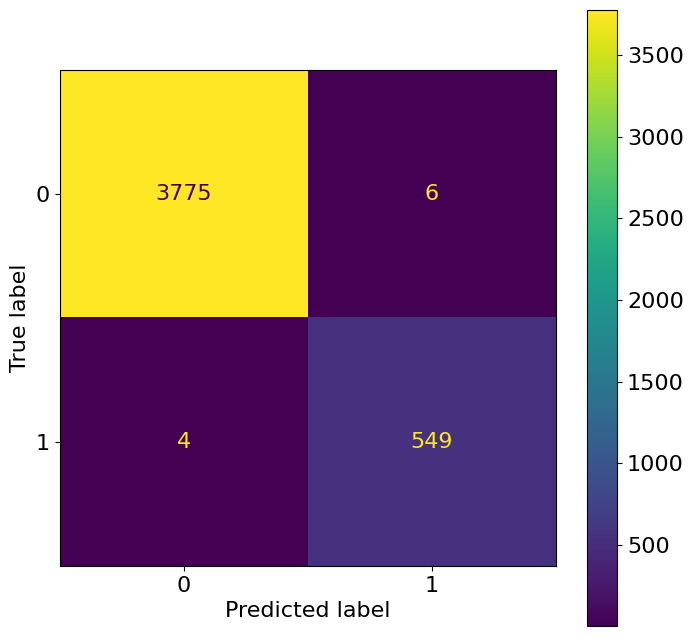

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot());

Es increible, el Random Forest solo detecta como no-fraudulentos 2 ejemplos que realmente sí que lo són. Todos los demas los clasifica correctamente. Hay ciertas características que permiten que el modelo sea muy bueno a la hora de tomar decisiones. En la siguiente tabla se ve como el Random Forest es claramente el mejor modelo visto hasta el momento:

In [ ]:
show_html(results_df.sort_values(by='recall score (M)', ascending=False).to_html())

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Random Forest,0.998,0.998,0.994,0.996,0.995
Árbol de decisión,0.991,0.990,0.986,0.967,0.976
Logistic Regression CON class_weight,0.916,0.868,0.729,0.845,0.765
Logistic Regression SIN class_weight,0.904,0.943,0.929,0.802,0.851


### Gradient Boosting

Ahora ajustaremos un gradient boosting explorando adecuadamente los hiperparámetros. Gradient Boosting es un modelo que se construye additivamente, cada modelo se especializa en el residuo del árbol anterior. En este caso tampoco es necesario usar los datos estandarizados o normalizados.

In [ ]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'loss':['log_loss', 'exponential'],
         'criterion':['friedman_mse', 'squared_error'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10],
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=50, cv=5, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
34,"{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'exponential', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 50}",0.998,1
32,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 50}",0.998,2
30,"{'criterion': 'friedman_mse', 'learning_rate': 3, 'loss': 'exponential', 'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 50}",0.997,3
48,"{'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'exponential', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 50}",0.996,4
31,"{'criterion': 'squared_error', 'learning_rate': 3, 'loss': 'exponential', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 75}",0.996,5


Vemos resultados parecidos a los de Random Forest en la partición de train. Vamos a ver como se comporta en la partición de test:

In [ ]:
print(classification_report(y_test, gb_bs.predict(X_test)))
results_df = save_results(gb_bs, X_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      1.00      0.99       553

    accuracy                           1.00      4334
   macro avg       0.99      1.00      0.99      4334
weighted avg       1.00      1.00      1.00      4334



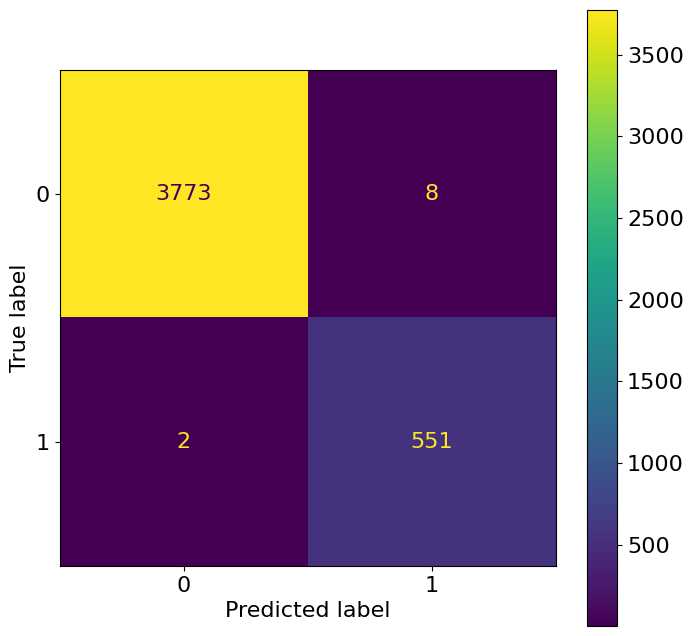

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test,y_test, ax=plt.subplot());

Podemos ver que el Gradient Booster es ligeramente mas preciso en la clase priotitaria pero ha perdido un poco de recall en ella. El modelo sigue siendo muy bueno, pero puestos a escoger eligiríamos el random forest, tiene mas recall en la classe de transacciones fraudulentas.

In [ ]:
show_html(results_df.sort_values(by='recall score (M)', ascending=False).to_html())

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Gradient Boosting,0.998,0.998,0.993,0.997,0.995
Random Forest,0.998,0.998,0.994,0.996,0.995
Árbol de decisión,0.991,0.990,0.986,0.967,0.976
Logistic Regression CON class_weight,0.916,0.868,0.729,0.845,0.765
Logistic Regression SIN class_weight,0.904,0.943,0.929,0.802,0.851


## Apartado E

Las SVM se benefician de datos con alta dimensionalidad, ajustad una SVM lineal, una con kernel cuadrático y otra con kernel RBF explorando adecuadamente sus hiperparámetros. Tendréis que hacer que los modelos predigan probabilidades para poder ver la curva ROC. Comparad los resultados con los modelos anteriores.

### SVM Lineal

Primero de todo, deberemos hacer una exploración de los hiperparametros del modelo. Para el caso del kernel lineal no hay muchos hiperparametros a explorar fuera de la regularización y la tolerancia.

Visto que queremos sacar la Curva ROC debemos activar el campo `Probability`; esto hace que la exploracion sea aun mas lenta por lo que vamos a bajar el numero de iteraciones para obtener resultados en un tiempo razonable.

A diferencia de los arboles de descisión, con las SVM sí es necesario transformar los datos.

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_linear_params = {
    'C': 10**np.linspace(-3,3,5),
    'tol': 10**np.linspace(-5, -1, 5)
}

lsvc = SVC(kernel='linear', probability=True, max_iter=5000,random_state=0)
lsvc_bs = BayesSearchCV(lsvc, svc_linear_params, n_iter=15, cv=5, n_jobs=-1, refit=True)

lsvc_bs.fit(X_train_norm, y_train);

/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: Conve

Habiendo explorado los hiperparametros vemos que lo que marca la diferencia es el valor de regularización, ya que las mejores configuracion tienen el mismo valor.

In [ ]:
print('Ranking Configuracion SVM Lineal')
show_html(pd.DataFrame(lsvc_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Ranking Configuracion SVM Lineal


,params,mean_test_score,rank_test_score
12,"{'C': 1.0, 'tol': 0.1}",0.926,1
0,"{'C': 1.0, 'tol': 0.0001}",0.925,2
4,"{'C': 1.0, 'tol': 0.0001}",0.925,2
3,"{'C': 1.0, 'tol': 1e-05}",0.925,2
13,"{'C': 1.0, 'tol': 0.01}",0.925,2


Vemos que el modelo, como los anteriores, da resultados muy buenos (casi perfectos) con la clase mayoritaria. Aun así, la clase minoritaria obtiene un resultado considerablemente mediocre en la recuperación, aunque con una precisión mas que buena.

In [ ]:
print(classification_report(y_test, lsvc_bs.predict(X_test_norm)))
results_df = save_results(lsvc_bs, X_test_norm, y_test, 'SVM Lineal', results_df)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3781
           1       0.90      0.51      0.65       553

    accuracy                           0.93      4334
   macro avg       0.92      0.75      0.81      4334
weighted avg       0.93      0.93      0.92      4334



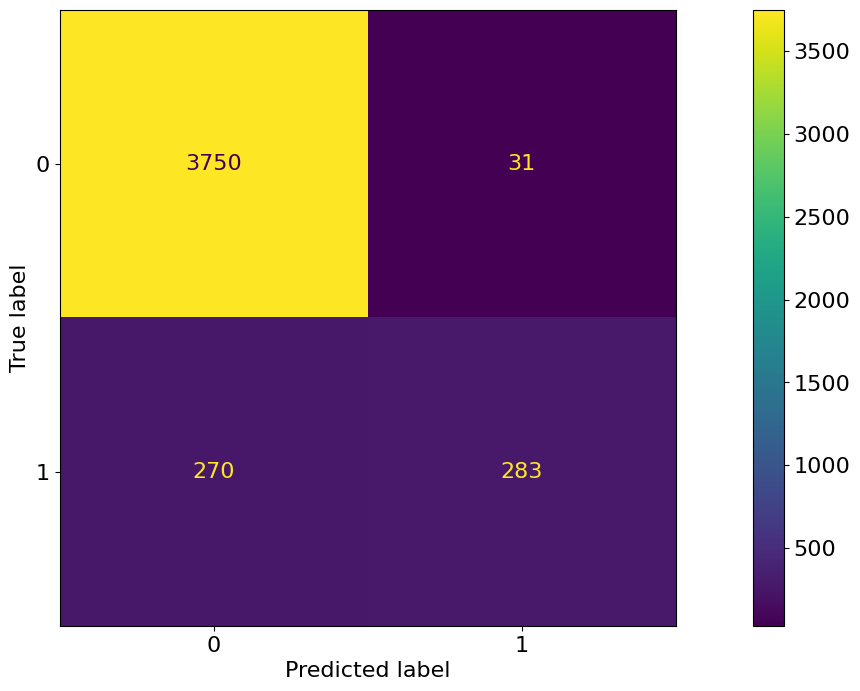

In [ ]:
plt.figure(figsize=(20,8));
ConfusionMatrixDisplay.from_estimator(lsvc_bs, X_test_norm,y_test, ax=plt.subplot());

### SVM Kernel Quadratico

Con kernels polinómicos el numero de hiperparametros a ajustar es algo mayor

In [ ]:
svc_quadratic_params = {
    'C': 10**np.linspace(-3,3,5),
    'tol': 10**np.linspace(-5, -1, 5),
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.2, 0.5, 1],
}

qsvc = SVC(kernel='poly', degree=2, probability=True, max_iter=5000,random_state=0)
qsvc_bs = BayesSearchCV(qsvc, svc_quadratic_params, n_iter=15, cv=5, n_jobs=-1, refit=True)

qsvc_bs.fit(X_train_norm, y_train);

/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: Conve

Habiendo ajustado los hiperparametros vemos que un valor de regularizacion de $\approx$ 31 es lo que mas determina la calidad del modelo. Aun asi, vemos que hay valores con cierta importancia, como el coeficiento nº0 y la tolerancia. Vemos que hay dos configuraciones (salen 4 con el mismo valor pero por el ranking vemos que son 2) que dan el mismo resultado por lo que nos quedaremos con cualquiera de las dos.

In [ ]:
print('Ranking Configuracion SVM Cuadratico')
show_html(pd.DataFrame(qsvc_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Ranking Configuracion SVM Cuadratico


,params,mean_test_score,rank_test_score
0,"{'C': 1000.0, 'coef0': 0.5, 'gamma': 'auto', 'tol': 0.001}",0.992,1
11,"{'C': 1000.0, 'coef0': 0.5, 'gamma': 'auto', 'tol': 0.01}",0.992,1
8,"{'C': 1000.0, 'coef0': 0.2, 'gamma': 'auto', 'tol': 0.1}",0.992,3
1,"{'C': 1000.0, 'coef0': 1, 'gamma': 'scale', 'tol': 0.1}",0.991,4
4,"{'C': 1000.0, 'coef0': 1, 'gamma': 'scale', 'tol': 1e-05}",0.991,4


Con este nuevo modelo obtenemos resultados casi perfectos en la clase mayoritaria; de hecho es casi perfecto en general. Respecto al modelo anterior vemos que tanto la recuperacion como la precision de la clase minoritaria son practicamente perfectas.

Aun así, viendo la matriz de confusión, es evidente que hay modelos, como los del apartado d), que funcionan mucho mejor.

In [ ]:
print(classification_report(y_test, qsvc_bs.predict(X_test_norm)))
results_df = save_results(qsvc_bs, X_test_norm, y_test, 'SVM Cuadratico', results_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      0.97      0.98       553

    accuracy                           0.99      4334
   macro avg       0.99      0.98      0.99      4334
weighted avg       0.99      0.99      0.99      4334



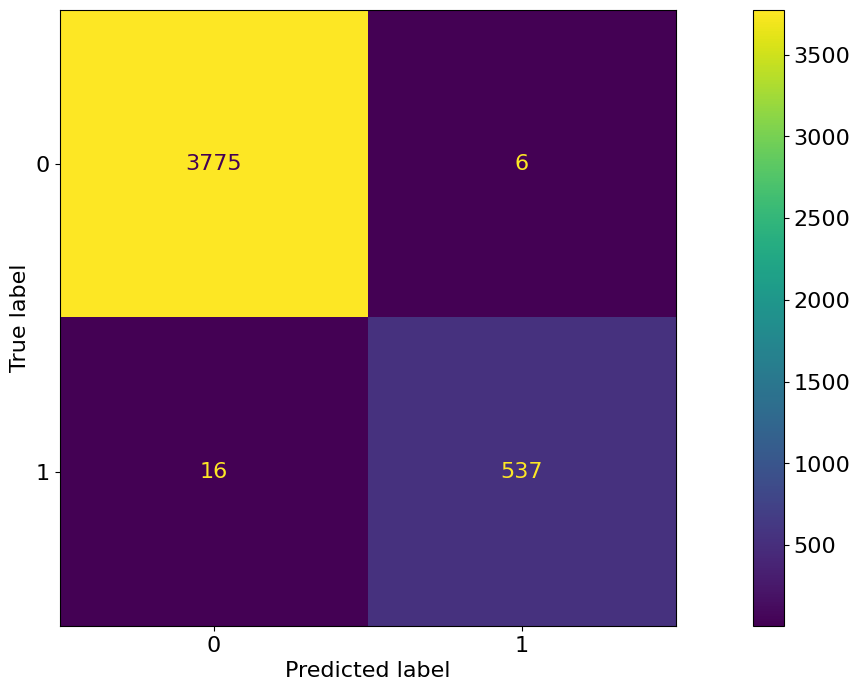

In [ ]:
plt.figure(figsize=(20,8));
ConfusionMatrixDisplay.from_estimator(qsvc_bs, X_test_norm,y_test, ax=plt.subplot());

### SVM Kernel RBF

In [ ]:
svc_brf_params = {
    'C': 10**np.linspace(-3,3,5),
    'tol': 10**np.linspace(-5, -1, 5),
    'gamma': ['scale', 'auto'],
}

rbfsvc = SVC(kernel='rbf', probability=True, max_iter=5000,random_state=0)
rbfsvc_bs = BayesSearchCV(rbfsvc, svc_brf_params, n_iter=15, cv=5, n_jobs=-1, refit=True)

rbfsvc_bs.fit(X_train_norm, y_train);

/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: Conve

In [ ]:
print('Ranking Configuracion SVM Kernel RBF')
show_html(pd.DataFrame(rbfsvc_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Ranking Configuracion SVM Kernel RBF


,params,mean_test_score,rank_test_score
6,"{'C': 1000.0, 'gamma': 'auto', 'tol': 0.01}",0.993,1
12,"{'C': 1000.0, 'gamma': 'auto', 'tol': 1e-05}",0.993,1
10,"{'C': 1000.0, 'gamma': 'auto', 'tol': 0.001}",0.993,1
9,"{'C': 1000.0, 'gamma': 'auto', 'tol': 0.0001}",0.993,1
8,"{'C': 31.622776601683793, 'gamma': 'scale', 'tol': 0.001}",0.993,5


Los resultados del SVM con kernel RBF son practicamente iguales al con kernel quadratico. Aun así hay una pequeñisima diferencia ya que, viendo la matriz de confusión, es un poquito mas ajustada para con la recuperación de la clase minoritaria.

In [ ]:
print(classification_report(y_test, rbfsvc_bs.predict(X_test_norm)))
results_df = save_results(qsvc_bs, X_test_norm, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.98      0.98      0.98       553

    accuracy                           0.99      4334
   macro avg       0.99      0.99      0.99      4334
weighted avg       0.99      0.99      0.99      4334



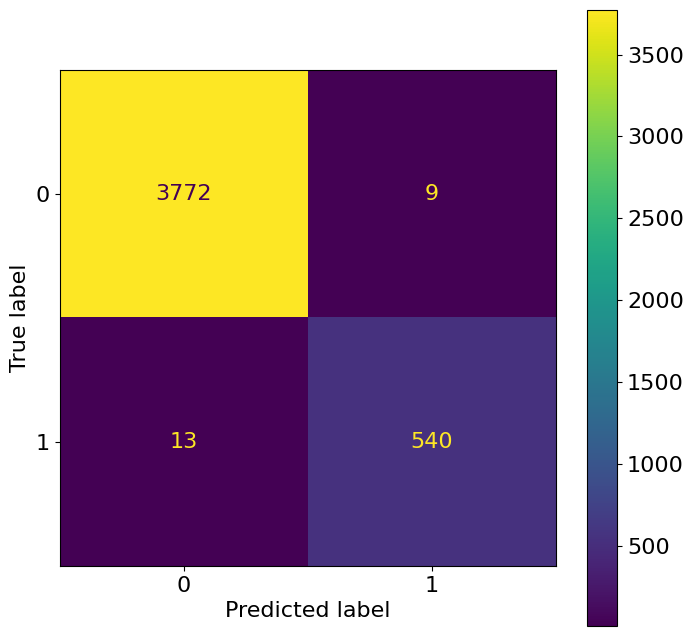

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbfsvc_bs, X_test_norm,y_test, ax=plt.subplot());

### Curva ROC

In [ ]:
l_y_score = lsvc_bs.best_estimator_.predict_proba(X_test_norm)[:, 1];

l_fpr, l_tpr, _ = roc_curve(y_test, l_y_score);
l_roc_auc = auc(l_fpr, l_tpr)

In [ ]:
q_y_score = qsvc_bs.best_estimator_.predict_proba(X_test_norm)[:, 1];

q_fpr, q_tpr, _ = roc_curve(y_test, q_y_score);
q_roc_auc = auc(q_fpr, q_tpr)

In [ ]:
rbf_y_score = rbfsvc_bs.best_estimator_.predict_proba(X_test_norm)[:, 1];

rbf_fpr, rbf_tpr, _ = roc_curve(y_test, rbf_y_score);
rbf_roc_auc = auc(rbf_fpr, rbf_tpr)

Viendo la curva se confirma lo que pensabamos de los modelos que hemos visto, el cuadratico y rbf son mejores que el lineal. También vemos que la curva para el cuadratico y rbf son, no solo similares, sino practicamente perfecta. Además, como hemos visto en la matriz de confusión, hay un corte en el el modelo con kernel RBF es mejor que el modelo con kernel cuadratico; no es mucho pero ahí está.

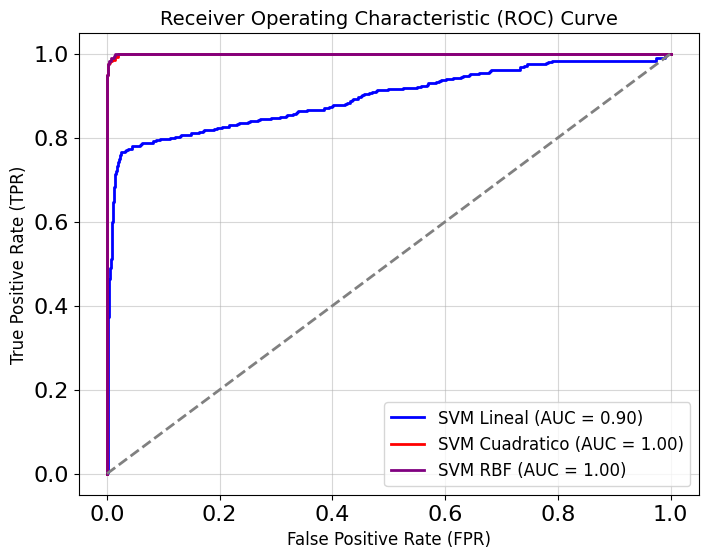

In [ ]:
plt.figure(figsize=(8, 6))
plt.title(f'Curva ROC')
plt.plot(l_fpr, l_tpr, color='blue', lw=2, label=f'SVM Lineal (AUC = {l_roc_auc:.2f})')
plt.plot(q_fpr, q_tpr, color='red', lw=2, label=f'SVM Cuadratico (AUC = {q_roc_auc:.2f})')
plt.plot(rbf_fpr, rbf_tpr, color='purple', lw=2, label=f'SVM RBF (AUC = {rbf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.show()

## Apartado F

Como hemos visto en teoría, cuando tenemos varios modelos podemos combinarlos usando diferentes estrategias. Entrenad un `StackedRegressor` y un `VotingRegressor` combinando los tres mejores modelos que habéis encontrado en los apartados anteriores con sus mejores hiperparámetros. ¿Es mejor alguno de estos modelos combinados?

Hasta ahora los mejores modelos que hemos encontrado han sido, en este orden: Gradient Boosting, Random Forest y los SVM con kernel RBF (en el ranking no se aprecia pero la matriz de confusión del RBF tiene una recuperación ligeramente mayor a la del kernel cuadrático).

In [ ]:
show_html(results_df.sort_values(by='f1 score (M)', ascending=False).to_html())

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Gradient Boosting,0.998,0.998,0.993,0.997,0.995
Random Forest,0.998,0.998,0.994,0.996,0.995
SVM Cuadratico,0.992,0.995,0.992,0.985,0.989
SVM RBF,0.992,0.995,0.992,0.985,0.989
Árbol de decisión,0.991,0.990,0.986,0.967,0.976
Logistic Regression SIN class_weight,0.904,0.943,0.929,0.802,0.851
SVM Lineal,0.926,0.931,0.917,0.752,0.807
Logistic Regression CON class_weight,0.916,0.868,0.729,0.845,0.765


In [ ]:
best_estimators_1 = [
    ('gb', gb_bs.best_estimator_),
    ('rf', rf_bs.best_estimator_),
    ('rbf_svc', rbfsvc_bs.best_estimator_)
]

`Stacking Regressor` y `Voting Regressor` estan pensados para que sus estimadores sean modelos de regresión. Para el problema hemos usado `Stacked Classifier` y `Voting Classifier` ya que es uno de clasificación.

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [ ]:
sr1 = StackingClassifier(best_estimators_1, cv=5, n_jobs=-1);
vr1 = VotingClassifier(best_estimators_1, n_jobs=-1);

sr1.fit(X_train_norm, y_train);
vr1.fit(X_train_norm, y_train);

/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/alexgarces/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:304: Conve

Usando tanto la combinación de modelos por el metodo `Stacking` como con el metodo `Voting` obtenemos modelos con un muy buen resultado. Aun así, el mejor modelo es el `Stacked`. Con este modelo obtenemos para las dos clases una precisión y recuperación equivalentes a las del mejor modelo para cada campo (i.e. Gradient Boosting para la recuperación y Random Forest para la precisión).

In [ ]:
print("Stacked Classifier\n")
print(classification_report(y_test, sr1.predict(X_test_norm)))
results_df = save_results(sr1, X_test_norm, y_test, 'Stacked Classifier (GB + RF + SVC (RBF))', results_df)

print("Voting Classifier\n")
print(classification_report(y_test, vr1.predict(X_test_norm)))
results_df = save_results(vr1, X_test_norm, y_test, 'Voting Classifier (GB + RF + SVC (RBF))', results_df)

Stacked Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      1.00      0.99       553

    accuracy                           1.00      4334
   macro avg       0.99      1.00      1.00      4334
weighted avg       1.00      1.00      1.00      4334

Voting Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      0.99      0.99       553

    accuracy                           1.00      4334
   macro avg       0.99      1.00      0.99      4334
weighted avg       1.00      1.00      1.00      4334



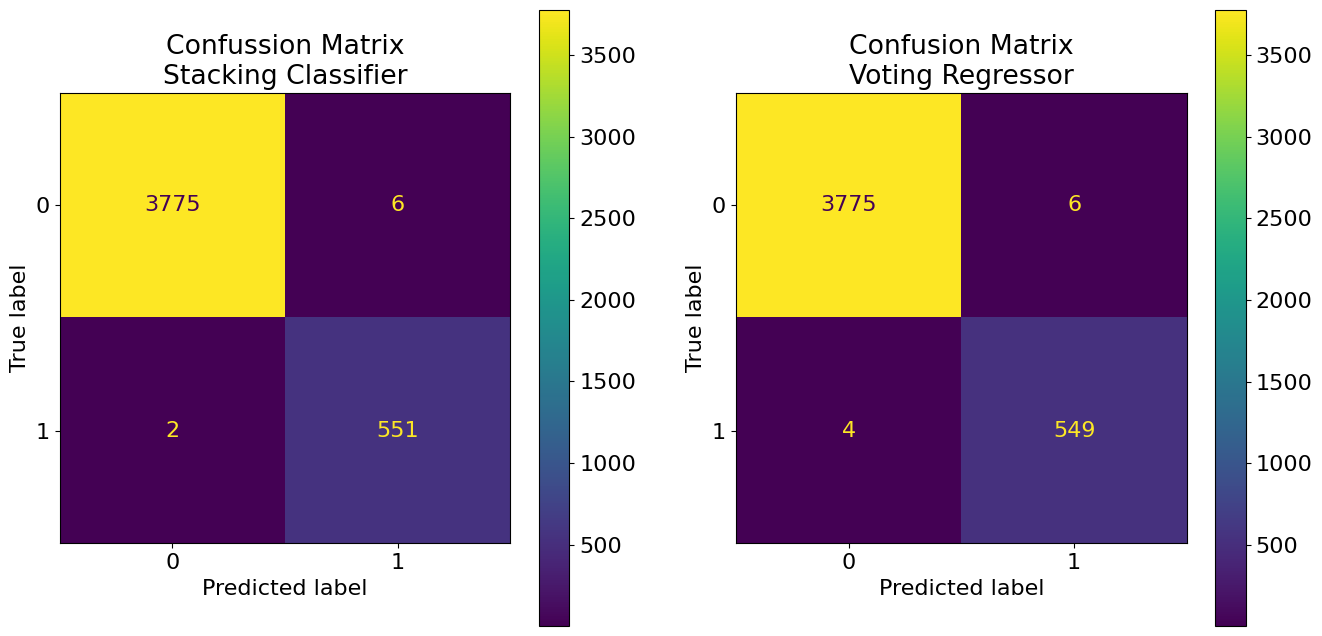

In [ ]:
plt.figure(figsize=(16,8));
ax1=plt.subplot(1, 2, 1)
ax1.set_title("Confussion Matrix\nStacking Classifier")
ax2=plt.subplot(1, 2, 2)
ax2.set_title('Confusion Matrix\nVoting Regressor')
ConfusionMatrixDisplay.from_estimator(sr1, X_test_norm,y_test, ax=ax1);
ConfusionMatrixDisplay.from_estimator(vr1, X_test_norm,y_test, ax=ax2);

Ya que la distancia en resultado entre el segundo y tercer modelo es bastante mas que la del primero y el segundo hemos probado a calcular el Stacked y Voting Classifiers pero con tan solo los dos mejores modelos. El resultado que obtenemos es practicamente el mismo en los dos casos exceptuando la recuperacion de la clase mayoritaria, en donde vemos como un ejemplo no fraudulento de mas ha sido categorizado como tal.

In [ ]:
best_estimators_2 = [
    ('gb', gb_bs.best_estimator_),
    ('rf', rf_bs.best_estimator_)
]

In [ ]:
sr2 = StackingClassifier(best_estimators_2, cv=5, n_jobs=-1);
vr2 = VotingClassifier(best_estimators_2, n_jobs=-1);

sr2.fit(X_train, y_train);
vr2.fit(X_train, y_train);

In [ ]:
print("Stacked Classifier\n")
print(classification_report(y_test, sr2.predict(X_test)))
results_df = save_results(sr2, X_test, y_test, 'Stacked Classifier (GB + RF)', results_df)

print("Voting Classifier\n")
print(classification_report(y_test, vr2.predict(X_test)))
results_df = save_results(vr2, X_test, y_test, 'Voting Classifier (GB + RF)', results_df)

Stacked Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      1.00      0.99       553

    accuracy                           1.00      4334
   macro avg       1.00      1.00      1.00      4334
weighted avg       1.00      1.00      1.00      4334

Voting Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3781
           1       0.99      0.99      0.99       553

    accuracy                           1.00      4334
   macro avg       0.99      1.00      1.00      4334
weighted avg       1.00      1.00      1.00      4334



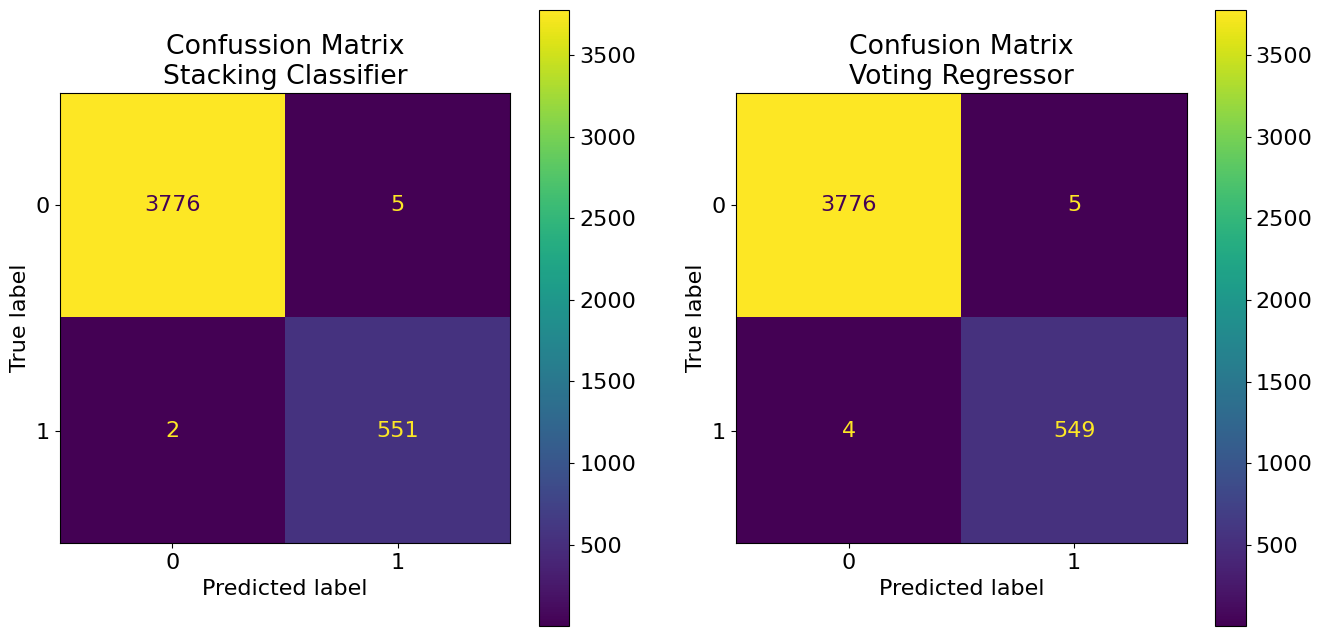

In [ ]:
plt.figure(figsize=(16,8));
ax1=plt.subplot(1, 2, 1)
ax1.set_title("Confussion Matrix\nStacking Classifier")
ax2=plt.subplot(1, 2, 2)
ax2.set_title('Confusion Matrix\nVoting Regressor')
ConfusionMatrixDisplay.from_estimator(sr2, X_test,y_test, ax=ax1);
ConfusionMatrixDisplay.from_estimator(vr2, X_test,y_test, ax=ax2);

## Apartado G

Calculad la permutation importance de los atributos sobre el test para el mejor modelo que habéis encontrado excepto el árbol de decisión ¿coincide la importancia de los atributos con los que considera el árbol en sus decisiones?

In [1]:
show_html(results_df.sort_values(by='f1 score (M)', ascending=False).to_html())

NameError: name 'show_html' is not defined